# Load

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
from scipy import sparse
from scipy.optimize import fsolve,minimize

In [ ]:
from scDenorm.denorm import *

In [ ]:
from scAnnot.tools import *

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def fit_nb(ms):
    
    def nb_func(x, phi):
        return x[0] + (phi * x[0] ** 2)
    
    popt, _ = curve_fit(nb_func, ms['mean'], ms['var'], p0=[1])
    phi = popt[0]
    
    ms['zeros_p'] = np.exp(-ms['mean'])
    ms['zeros_nb'] = (1 + phi * ms['mean']) ** (-1 / phi)
    ms['newVar'] = ms['mean'] + phi * ms['mean'] ** 2
    return ms

In [ ]:
def plot_mv(cmean,cvar,c='blue',fit=False,save=None):
    fig, ax = plt.subplots()
    ax.loglog()
    ax.scatter(cmean, cvar,s=20,c=c)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, linestyle='--', linewidth=2, alpha=0.75, zorder=0,color='black', label='line')
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Mean',fontsize=18)
    ax.set_ylabel('Variance',fontsize=18)
    
    if fit:
        ms=pd.DataFrame({'mean':cmean[0],'var':cvar[0]})
        ms=fit_nb(ms)
        ms=ms.sort_values('mean')
        plt.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)

# Data

In [ ]:
with open(f'data/results/ucb_all.pickle', 'rb') as handle:
    ads=pickle.load(handle)

In [ ]:
len(ads.keys())

43

In [ ]:
ads

{'adult-testis': View of AnnData object with n_obs × n_vars = 1000 × 27826
     obs: 'CellType', 'Source', 'UMI Count', 'log1p_n_counts', 'Expressed Genes', 'log1p_n_genes', 'Percent Mitochond.', 'percent_ribo', 'percent_hb', 'percent_top50',
 'aging-brain': View of AnnData object with n_obs × n_vars = 1000 × 19746
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Batch', 'Age', 'Celltype', 'Subtype', 'RNA_snn_res.1.6', 'seurat_clusters', 'Cluster',
 'autism': View of AnnData object with n_obs × n_vars = 1000 × 36501
     obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent',
 'brain-dronc-seq': View of AnnData object with n_obs × n_vars = 1000 × 25587
     obs: 'CellType', 'UMI Count', 'log1p_n_counts', 'Expressed Genes', 'log1p_n_genes', 'Percent Mitochond.', 'percent_ribo', 'per

In [ ]:
ads.keys()

dict_keys(['adult-testis', 'aging-brain', 'autism', 'brain-dronc-seq', 'cbl-dev', 'colorectal-cancer', 'cortex-dev', 'covid19-cytokine-storm', 'covid19-periph-immuno', 'fetal-liver', 'fetal-lung', 'gbm', 'gtex8', 'h1-esc-diff', 'head-neck', 'healthy-bal', 'hpsc-embryo-model', 'human-cellular-landscape', 'human-cornea', 'human-epidermis', 'human-fovea-periphery', 'human-gallbladder', 'human-hippo-axis', 'human-ileum', 'human-liver', 'human-pancreas', 'klein-xenopus', 'living-donor-kidney', 'ln-mono-dc', 'lung-interstitial-macrophage', 'lung-smoking-effect', 'mouse-cell-atlas', 'mouse-dev-neocortex', 'mouse-esophagus', 'mouse-hypothalamus-dev', 'mouse-osteoblasts', 'mouse-skin-stretch', 'ms', 'organoidatlas', 'prostate-prostatic-urethra', 'retinal-pigment-epi', 'sea-urchin-dev', 'zeisel2015'])

In [ ]:
ads['cbl-dev']

View of AnnData object with n_obs × n_vars = 1000 × 2000
    obs: 'Cluster', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'age', 'figure_clusters', 'sex', 'type', 'experiment'

In [ ]:
h5_names=['adult-testis', 'aging-brain', 'brain-dronc-seq', 'colorectal-cancer', 'covid19-cytokine-storm', 'covid19-periph-immuno','fetal-liver', 'fetal-lung', 'hpsc-embryo-model', 'human-cellular-landscape', 'human-cornea', 'human-epidermis', 'human-fovea-periphery', 'human-gallbladder', 'human-hippo-axis', 'human-ileum', 'human-pancreas',  'living-donor-kidney', 'ln-mono-dc', 'lung-interstitial-macrophage', 'lung-smoking-effect', 'mouse-cell-atlas', 'mouse-dev-neocortex', 'mouse-esophagus', 'mouse-osteoblasts',  'prostate-prostatic-urethra', 'retinal-pigment-epi', 'sea-urchin-dev']

In [ ]:
len(h5_names)

28

In [ ]:
total_sum=[]
for i in h5_names:
    print(i)
    smtx1=ads[i].X.copy()
    smtx1.data=np.exp(smtx1.data)-1
    total_sum.append(pd.DataFrame(smtx1.sum(axis=1)))

adult-testis
aging-brain
brain-dronc-seq
colorectal-cancer
covid19-cytokine-storm
covid19-periph-immuno
fetal-liver
fetal-lung
hpsc-embryo-model
human-cellular-landscape
human-cornea
human-epidermis
human-fovea-periphery
human-gallbladder
human-hippo-axis
human-ileum
human-pancreas
living-donor-kidney
ln-mono-dc
lung-interstitial-macrophage
lung-smoking-effect
mouse-cell-atlas
mouse-dev-neocortex
mouse-esophagus
mouse-osteoblasts
prostate-prostatic-urethra
retinal-pigment-epi
sea-urchin-dev


In [ ]:
for i,j in enumerate(h5_names):
    print(i,j,np.mean(total_sum[i])[0],np.std(total_sum[i])[0])

0 adult-testis 10000.0 0.0012881744
1 aging-brain 10000.0 0.000805886
2 brain-dronc-seq 10000.0 0.002515478
3 colorectal-cancer 10000.0 0.00063438993
4 covid19-cytokine-storm 9995.853 2.675778
5 covid19-periph-immuno 1542.548 93.809105
6 fetal-liver 10000.0 0.0009862798
7 fetal-lung 10000.0 0.0011270733
8 hpsc-embryo-model 10000.0 0.00060829736
9 human-cellular-landscape 1115.063 381.98047
10 human-cornea 10000.0 0.0008383662
11 human-epidermis 10000.0 0.0010129923
12 human-fovea-periphery 10001.83 17.660942
13 human-gallbladder 76.526 74.81244
14 human-hippo-axis 10000.0 0.0009377034
15 human-ileum 10000.0 0.0018814991
16 human-pancreas 10000.0 0.0014868145
17 living-donor-kidney 5996.943 863.71356
18 ln-mono-dc 11864.353 588.4526
19 lung-interstitial-macrophage 7292.123 516.1457
20 lung-smoking-effect 23344.82 1353.4865
21 mouse-cell-atlas 1859.2323 485.28137
22 mouse-dev-neocortex 10000.0 0.0007714226
23 mouse-esophagus 10000.0 0.0009024621
24 mouse-osteoblasts 10367.0 0.0010900818


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
total_sum=pd.concat(total_sum)

In [ ]:
total_sum.columns=['total']

In [ ]:
total_sum['name']=[x for x in h5_names for i in range(1000)]

In [ ]:
total_sum

,total,name
0,10000.001953,adult-testis
1,9999.999023,adult-testis
2,10000.000000,adult-testis
3,9999.998047,adult-testis
4,9999.998047,adult-testis
...,...,...
995,10000.000000,sea-urchin-dev
996,10000.000977,sea-urchin-dev
997,9999.999023,sea-urchin-dev
998,10000.000977,sea-urchin-dev


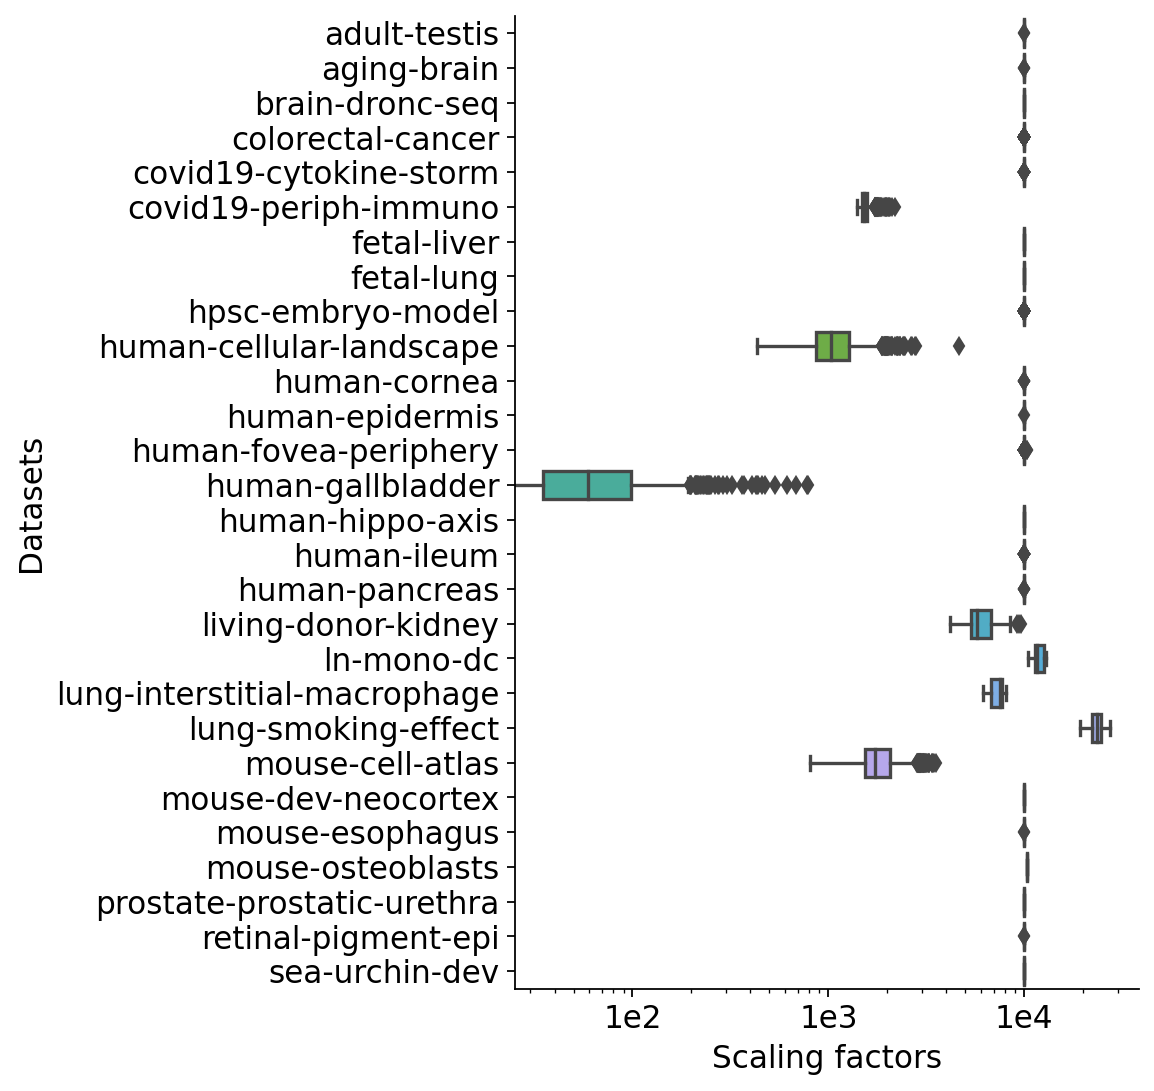

In [ ]:
figsize(5,8)
fig,ax=plt.subplots()
sns.boxplot(data=total_sum,y='name',x='total',ax=ax)
ax.set_xscale("log", base=10)
plt.grid(visible=False)
plt.xlabel('Scaling factors')
plt.ylabel('Datasets')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xticks = [1e2, 1e3, 1e4]
xtick_labels = ['1e2', '1e3', '1e4']
plt.xticks(xticks, xtick_labels)
plt.savefig('figures/UCB/scaling_factors_all.pdf',dpi=300, bbox_inches='tight',transparent=True)

# rounding errors

In [ ]:
ads_dn=[]
rounding_ers=[]
for i in h5_names:
    print(i)
    ad=ads[i]
    ad1=scdenorm(ad,verbose=1)
    ad1.X.sort_indices()
    
    ad2=scdenorm(ad,verbose=1,rint=False)
    ad2.X.sort_indices()

    tmp2=ad1.X.copy()
    tmp2.data=tmp2.data-ad2.X.data
    rounding_ers.append(tmp2.copy())
    ads_dn.append(ad1.X.copy())

INFO:root:The dimensions of this data are (1000, 27826).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


adult-testis


100%|██████████| 1000/1000 [00:00<00:00, 1679.38it/s]
INFO:root:The dimensions of this data are (1000, 27826).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1701.81it/s]
INFO:root:The dimensions of this data are (1000, 19746).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


aging-brain


100%|██████████| 1000/1000 [00:00<00:00, 1772.69it/s]
INFO:root:The dimensions of this data are (1000, 19746).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1777.64it/s]
INFO:root:The dimensions of this data are (1000, 25587).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


brain-dronc-seq


100%|██████████| 1000/1000 [00:00<00:00, 1828.43it/s]
INFO:root:The dimensions of this data are (1000, 25587).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1816.82it/s]
INFO:root:The dimensions of this data are (1000, 33694).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


colorectal-cancer


100%|██████████| 1000/1000 [00:00<00:00, 1655.10it/s]
INFO:root:The dimensions of this data are (1000, 33694).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1643.26it/s]
INFO:root:The dimensions of this data are (1000, 18670).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


covid19-cytokine-storm


100%|██████████| 1000/1000 [00:00<00:00, 1677.58it/s]
INFO:root:The dimensions of this data are (1000, 18670).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1652.61it/s]
INFO:root:The dimensions of this data are (1000, 26361).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


covid19-periph-immuno


100%|██████████| 1000/1000 [00:00<00:00, 1819.75it/s]
INFO:root:The dimensions of this data are (1000, 26361).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1804.56it/s]
INFO:root:The dimensions of this data are (1000, 26349).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


fetal-liver


100%|██████████| 1000/1000 [00:00<00:00, 1700.23it/s]
INFO:root:The dimensions of this data are (1000, 26349).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1675.57it/s]
INFO:root:The dimensions of this data are (1000, 23832).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


fetal-lung


100%|██████████| 1000/1000 [00:00<00:00, 1711.08it/s]
INFO:root:The dimensions of this data are (1000, 23832).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1705.96it/s]
INFO:root:The dimensions of this data are (1000, 19798).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


hpsc-embryo-model


100%|██████████| 1000/1000 [00:00<00:00, 1612.46it/s]
INFO:root:The dimensions of this data are (1000, 19798).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1585.57it/s]
INFO:root:The dimensions of this data are (1000, 1772).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-cellular-landscape


100%|██████████| 1000/1000 [00:00<00:00, 1856.85it/s]
INFO:root:The dimensions of this data are (1000, 1772).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1859.30it/s]
INFO:root:The dimensions of this data are (1000, 33538).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-cornea


100%|██████████| 1000/1000 [00:00<00:00, 1627.03it/s]
INFO:root:The dimensions of this data are (1000, 33538).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1675.14it/s]
INFO:root:The dimensions of this data are (1000, 19791).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-epidermis


100%|██████████| 1000/1000 [00:00<00:00, 1716.48it/s]
INFO:root:The dimensions of this data are (1000, 19791).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1727.53it/s]
INFO:root:The dimensions of this data are (1000, 21599).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-fovea-periphery


100%|██████████| 1000/1000 [00:00<00:00, 1773.87it/s]
INFO:root:The dimensions of this data are (1000, 21599).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1808.94it/s]
INFO:root:The dimensions of this data are (1000, 21).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-gallbladder


100%|██████████| 1000/1000 [00:00<00:00, 1795.94it/s]
INFO:root:The dimensions of this data are (1000, 21).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1786.63it/s]
INFO:root:The dimensions of this data are (1000, 17180).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-hippo-axis


100%|██████████| 1000/1000 [00:00<00:00, 1777.55it/s]
INFO:root:The dimensions of this data are (1000, 17180).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1760.51it/s]
INFO:root:The dimensions of this data are (1000, 22340).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-ileum


100%|██████████| 1000/1000 [00:00<00:00, 1805.84it/s]
INFO:root:The dimensions of this data are (1000, 22340).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1790.28it/s]
INFO:root:The dimensions of this data are (1000, 16077).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-pancreas


100%|██████████| 1000/1000 [00:00<00:00, 1706.54it/s]
INFO:root:The dimensions of this data are (1000, 16077).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1746.93it/s]
INFO:root:The dimensions of this data are (1000, 22484).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


living-donor-kidney


100%|██████████| 1000/1000 [00:00<00:00, 1749.61it/s]
INFO:root:The dimensions of this data are (1000, 22484).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1747.10it/s]
INFO:root:The dimensions of this data are (1000, 17863).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


ln-mono-dc


100%|██████████| 1000/1000 [00:00<00:00, 1647.66it/s]
INFO:root:The dimensions of this data are (1000, 17863).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1698.58it/s]
INFO:root:The dimensions of this data are (1000, 15171).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


lung-interstitial-macrophage


100%|██████████| 1000/1000 [00:00<00:00, 1715.78it/s]
INFO:root:The dimensions of this data are (1000, 15171).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1689.66it/s]
INFO:root:The dimensions of this data are (1000, 20952).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


lung-smoking-effect


100%|██████████| 1000/1000 [00:00<00:00, 1567.24it/s]
INFO:root:The dimensions of this data are (1000, 20952).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1576.27it/s]
INFO:root:The dimensions of this data are (1000, 3005).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-cell-atlas


100%|██████████| 1000/1000 [00:00<00:00, 1846.22it/s]
INFO:root:The dimensions of this data are (1000, 3005).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1874.26it/s]
INFO:root:The dimensions of this data are (1000, 14498).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-dev-neocortex


100%|██████████| 1000/1000 [00:00<00:00, 1758.20it/s]
INFO:root:The dimensions of this data are (1000, 14498).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1710.81it/s]
INFO:root:The dimensions of this data are (1000, 14389).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-esophagus


100%|██████████| 1000/1000 [00:00<00:00, 1793.72it/s]
INFO:root:The dimensions of this data are (1000, 14389).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1766.45it/s]
INFO:root:The dimensions of this data are (1000, 17275).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-osteoblasts


100%|██████████| 1000/1000 [00:00<00:00, 1668.87it/s]
INFO:root:The dimensions of this data are (1000, 17275).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1687.07it/s]
INFO:root:The dimensions of this data are (1000, 22875).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


prostate-prostatic-urethra


100%|██████████| 1000/1000 [00:00<00:00, 1716.07it/s]
INFO:root:The dimensions of this data are (1000, 22875).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1724.80it/s]
INFO:root:The dimensions of this data are (1000, 21040).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


retinal-pigment-epi


100%|██████████| 1000/1000 [00:00<00:00, 1736.43it/s]
INFO:root:The dimensions of this data are (1000, 21040).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1747.32it/s]
INFO:root:The dimensions of this data are (1000, 21823).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


sea-urchin-dev


100%|██████████| 1000/1000 [00:00<00:00, 1591.47it/s]
INFO:root:The dimensions of this data are (1000, 21823).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1606.85it/s]


In [ ]:
rounding_ers[0].data

array([ 0.0000000e+00, -4.7683716e-07,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  3.8146973e-06], dtype=float32)

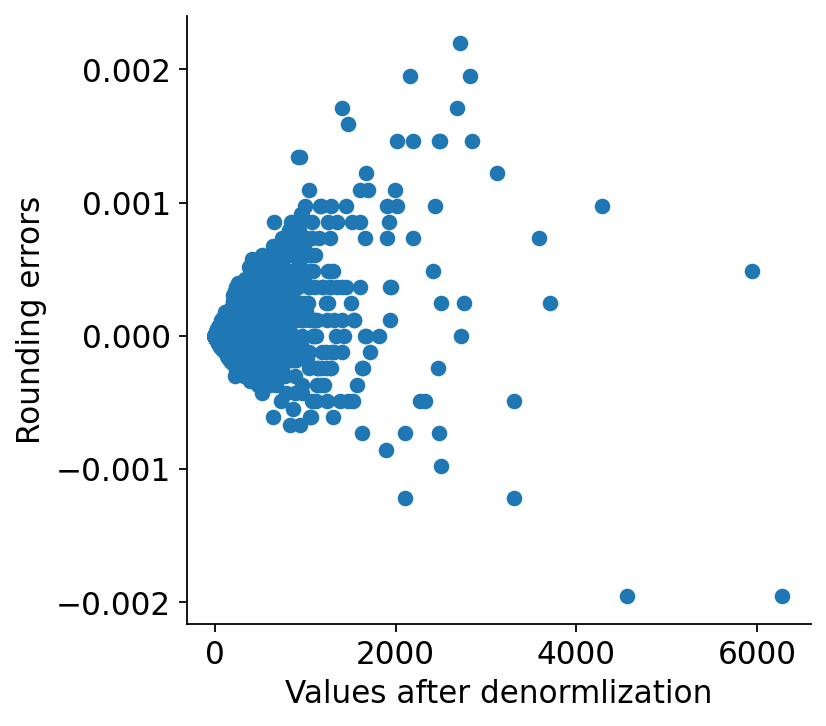

In [ ]:
figsize(5,5)
plt.plot(ads_dn[0].data,rounding_ers[0].data,'o')
plt.grid(visible=False)
plt.xlabel('Values after denormlization')
plt.ylabel('Rounding errors')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/UCB/rounding_errors.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
rounding_ers1=[]
for i,tmp2 in zip(h5_names,rounding_ers):
    tmp2=pd.DataFrame(tmp2.data)
    tmp2.columns=['error']
    tmp2['name']=i
    rounding_ers1.append(tmp2)

In [ ]:
rounding_ers1=pd.concat(rounding_ers1)

<AxesSubplot:xlabel='error', ylabel='name'>

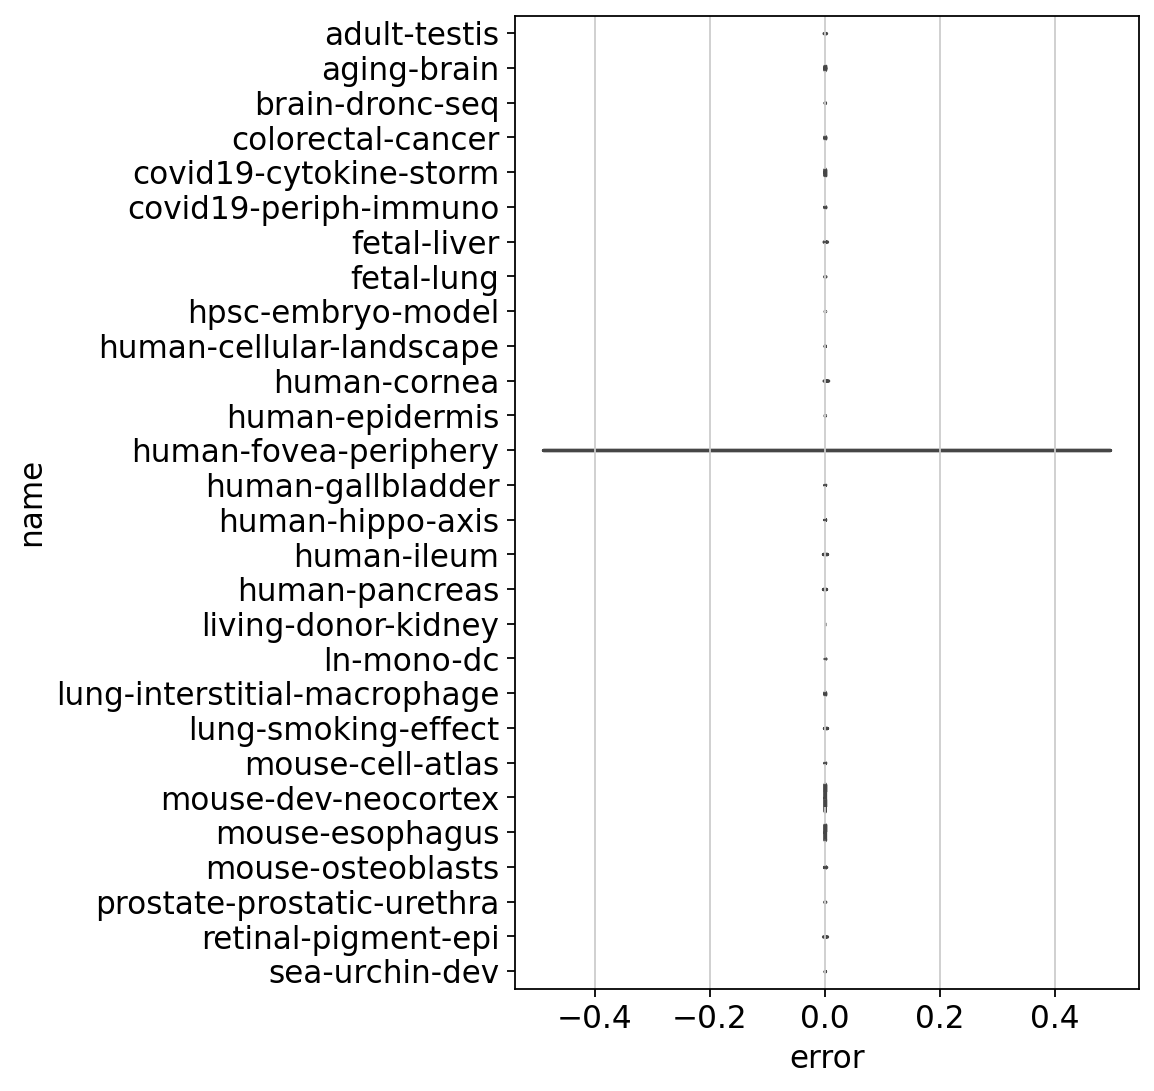

In [ ]:
fig,ax=plt.subplots()
sns.violinplot(data=rounding_ers1,y='name',x='error',inner="quartile",ax=ax)

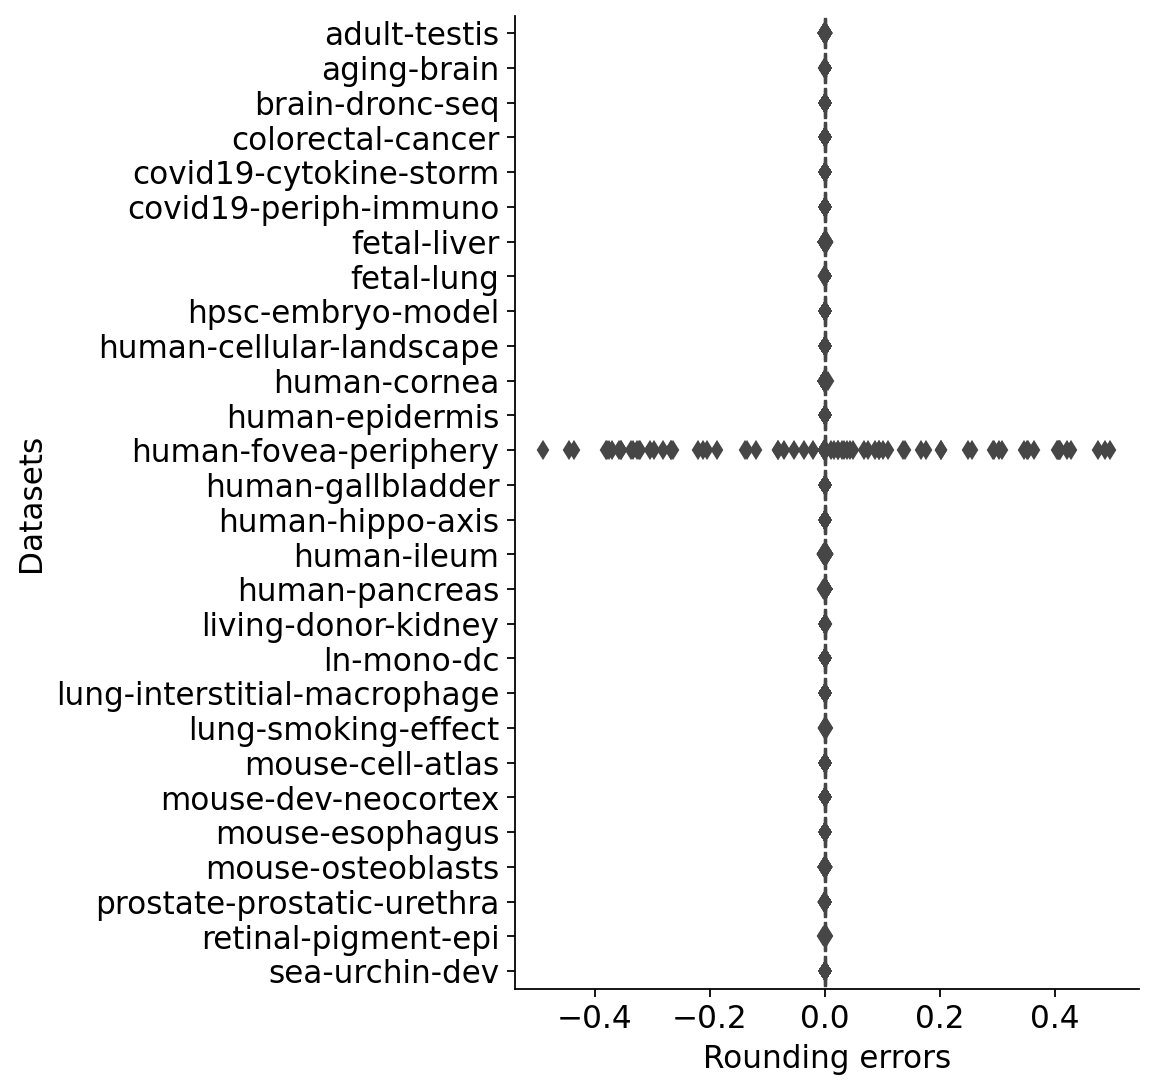

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=rounding_ers1,y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Rounding errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/rounding_errors1.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
rounding_ers1[rounding_ers1.name!='human-fovea-periphery']

,error,name
0,0.000000e+00,adult-testis
1,-4.768372e-07,adult-testis
2,0.000000e+00,adult-testis
3,0.000000e+00,adult-testis
4,0.000000e+00,adult-testis
...,...,...
3841527,0.000000e+00,sea-urchin-dev
3841528,0.000000e+00,sea-urchin-dev
3841529,0.000000e+00,sea-urchin-dev
3841530,0.000000e+00,sea-urchin-dev


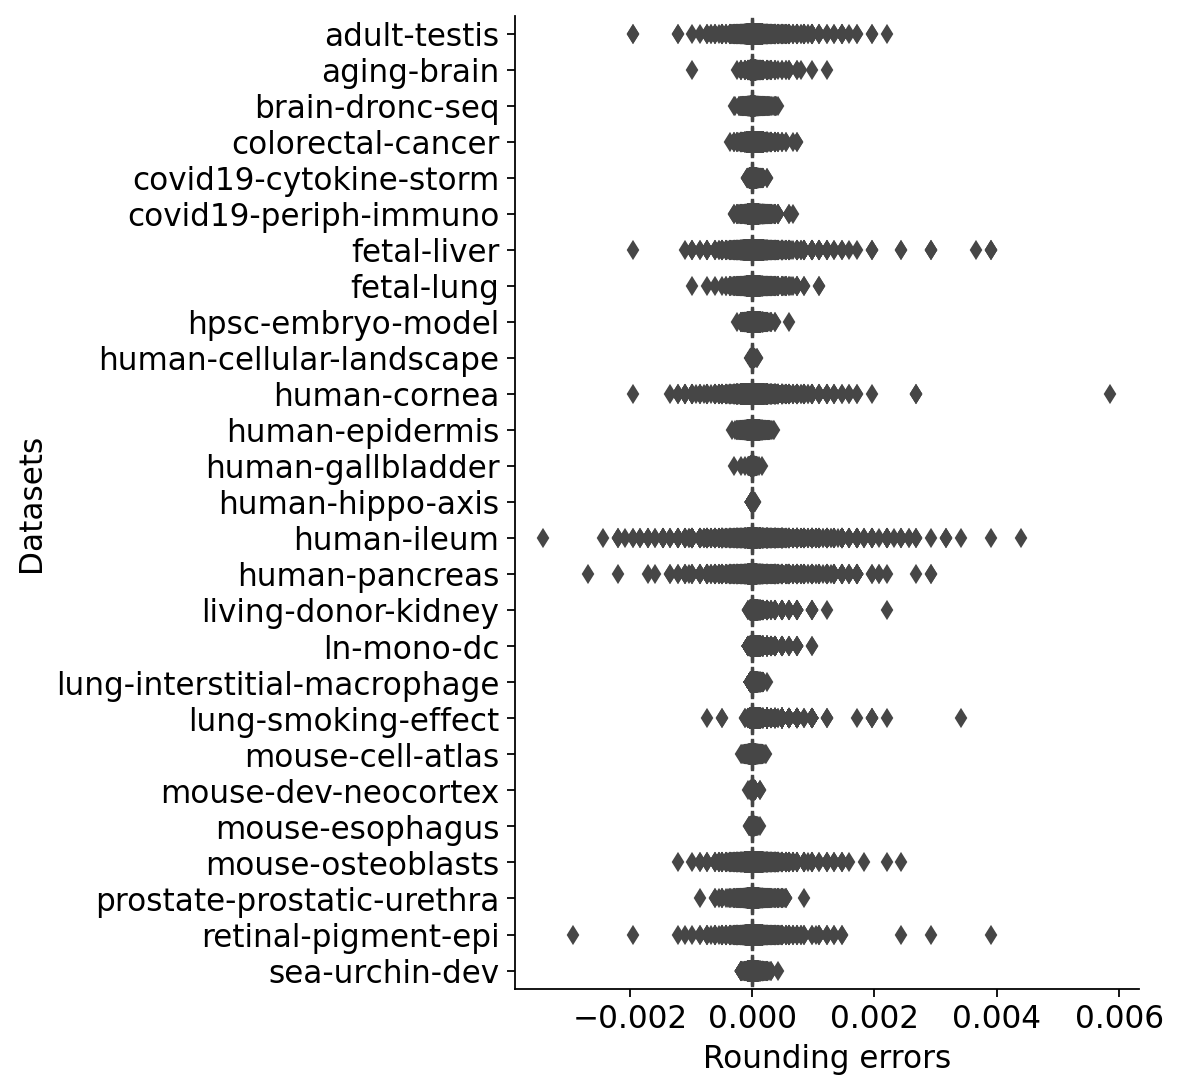

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=rounding_ers1[rounding_ers1.name!='human-fovea-periphery'],y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Rounding errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/rounding_errors2.pdf',dpi=300, bbox_inches='tight',transparent=True)

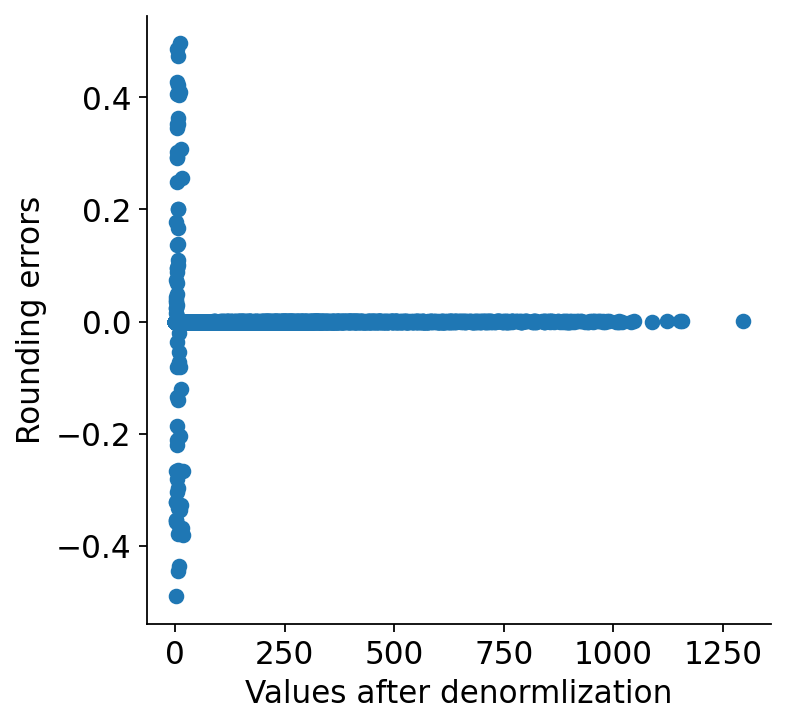

In [ ]:
figsize(5,5)
plt.plot(ads_dn[12].data,rounding_ers[12].data,'o')
plt.grid(visible=False)
plt.xlabel('Values after denormlization')
plt.ylabel('Rounding errors')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/UCB/rounding_errors_human-fovea-periphery.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
tmp=rounding_ers[12].todense()

In [ ]:
(ads_dn[12][((tmp>0.4).sum(axis=1)>0)]).shape

(1, 10)

In [ ]:
((tmp>0.4).sum(axis=1)>0).shape

(998, 1)

In [ ]:
ads_dn[12].shape

(998, 21599)

In [ ]:
ads['human-fovea-periphery'].obs

,final_cluster_labels,libraryID,celltype,region,disease_ontology_term_id,disease,sex,tissue_ontology_term_id,tissue,cell_type_ontology_term_id,cell_type
cellId,,,,,,,,,,,
AAACCCAGTCGGCACT-1,9,fovea_donor_1,Unknown,fovea,MONDO:0005041,glaucoma (disease),male,UBERON:0001786,fovea centralis,NaN,unknown
AAACGAACAGGGACTA-1,15,fovea_donor_1,Glial-F1,fovea,MONDO:0005041,glaucoma (disease),male,UBERON:0001786,fovea centralis,CL:0000125,glial cell
AAACGAAGTTCTCCAC-1,3,fovea_donor_1,Cones-Fov,fovea,MONDO:0005041,glaucoma (disease),male,UBERON:0001786,fovea centralis,NaN,foveal cone photoreceptor
AAACGAATCATAGCAC-1,5,fovea_donor_1,Bipolar-1,fovea,MONDO:0005041,glaucoma (disease),male,UBERON:0001786,fovea centralis,CL:0000103,bipolar neuron
AAACGCTAGGAGGCAG-1,8A,fovea_donor_1,Horizontal,fovea,MONDO:0005041,glaucoma (disease),male,UBERON:0001786,fovea centralis,CL:0000745,retina horizontal cell
...,...,...,...,...,...,...,...,...,...,...,...
AGAAATGGTAAGGCCA-2,15,fovea_donor_2,Glial-F1,fovea,PATO:0000461,normal,male,UBERON:0001786,fovea centralis,CL:0000125,glial cell
AGAAATGGTGGACAGT-2,11,fovea_donor_2,Endothelial,fovea,PATO:0000461,normal,male,UBERON:0001786,fovea centralis,CL:0000115,endothelial cell
AGAAATGTCACCACAA-2,5,fovea_donor_2,Bipolar-1,fovea,PATO:0000461,normal,male,UBERON:0001786,fovea centralis,CL:0000103,bipolar neuron


In [ ]:
ads['human-fovea-periphery'].obs.cell_type.value_counts()

bipolar neuron               306
glial cell                   186
retinal ganglion cell        170
unknown                      128
endothelial cell              53
retinal rod cell              52
foveal cone photoreceptor     45
retina horizontal cell        32
pericyte cell                 14
microglial cell               12
amacrine cell                  2
Name: cell_type, dtype: int64

## reconstruction errros

In [ ]:
h5_names1=['adult-testis', 'aging-brain', 'brain-dronc-seq', 'colorectal-cancer', 'covid19-cytokine-storm', 'fetal-liver', 'fetal-lung', 'hpsc-embryo-model',  'human-cornea', 'human-epidermis', 'human-fovea-periphery',  'human-hippo-axis', 'human-ileum', 'human-pancreas',  'mouse-dev-neocortex', 'mouse-esophagus', 'mouse-osteoblasts',  'prostate-prostatic-urethra', 'retinal-pigment-epi', 'sea-urchin-dev']

In [ ]:
recon_ers=[]
for i in h5_names1:
    ad=ads[i]
    ad.X.sort_indices()
    
    ad3=scdenorm(ad,verbose=1,cutoff=0.5)
    sc.pp.normalize_total(ad3, target_sum=10000)
    sc.pp.log1p(ad3)
    ad3.X.sort_indices()
    tmp2=ad.X.copy()
    tmp2.data=tmp2.data-ad3.X.data
    recon_ers.append(tmp2.copy())

INFO:root:The dimensions of this data are (1000, 27826).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1701.70it/s]
INFO:root:The dimensions of this data are (1000, 19746).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1778.58it/s]
INFO:root:The dimensions of this data are (1000, 25587).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1822.76it/s]
INFO:root:The dimensions of this data are (1000, 33694).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1681.22it/s]
INFO:root:The dimensions of this data are (1000, 18670).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1728.26it/s]
INFO:root:The dimensions of this data are (1000, 26349)

In [ ]:
recon_ers1=[]
for i,tmp2 in zip(h5_names1,recon_ers):
    tmp2=pd.DataFrame(tmp2.data)
    tmp2.columns=['error']
    tmp2['name']=i
    recon_ers1.append(tmp2)

In [ ]:
recon_ers1=pd.concat(recon_ers1)

<AxesSubplot:xlabel='error', ylabel='name'>

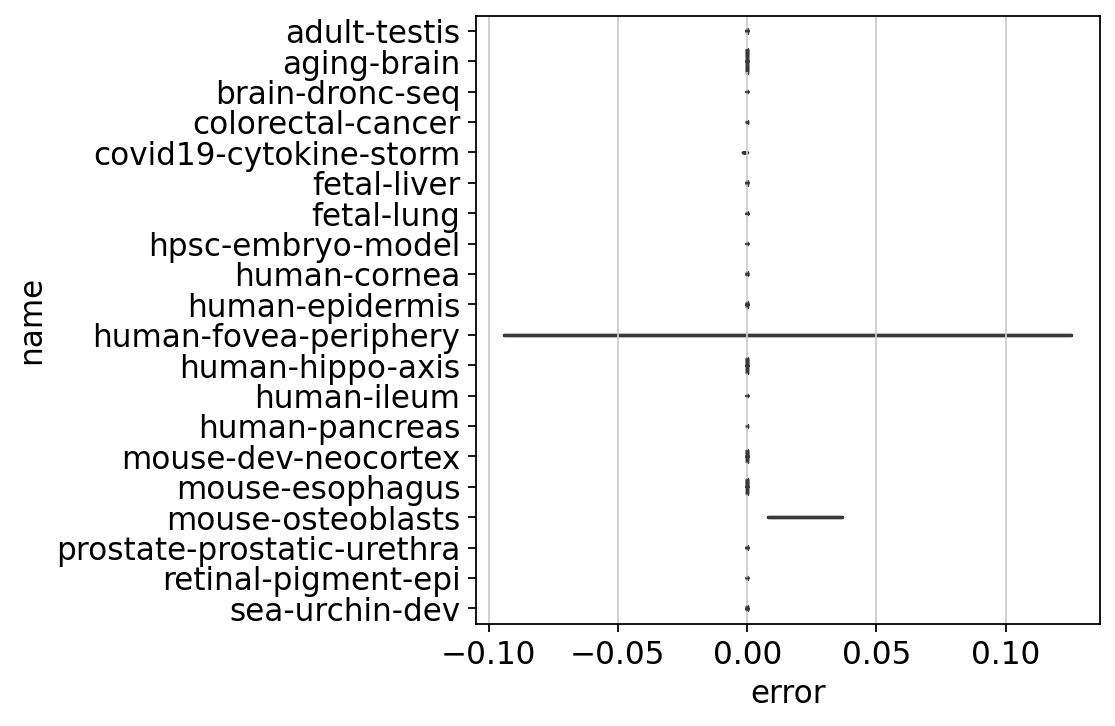

In [ ]:
fig,ax=plt.subplots()
sns.violinplot(data=recon_ers1,y='name',x='error',inner="quartile",ax=ax)

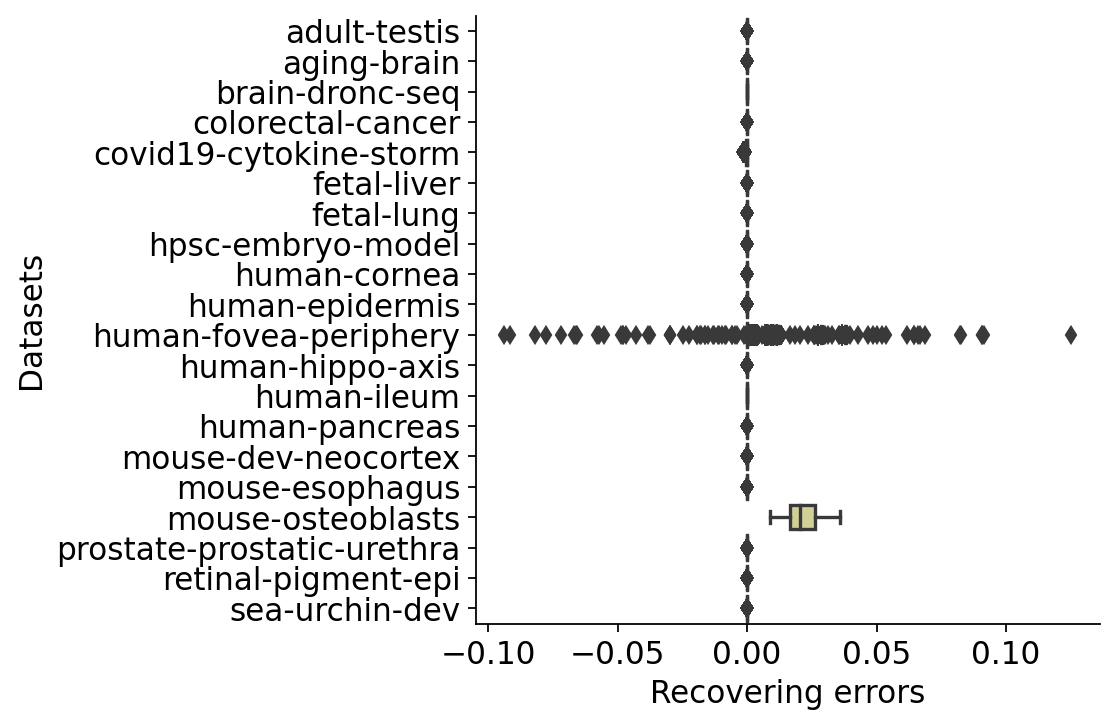

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=recon_ers1,y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Recovering errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/recon_errors1.pdf',dpi=300, bbox_inches='tight',transparent=True)

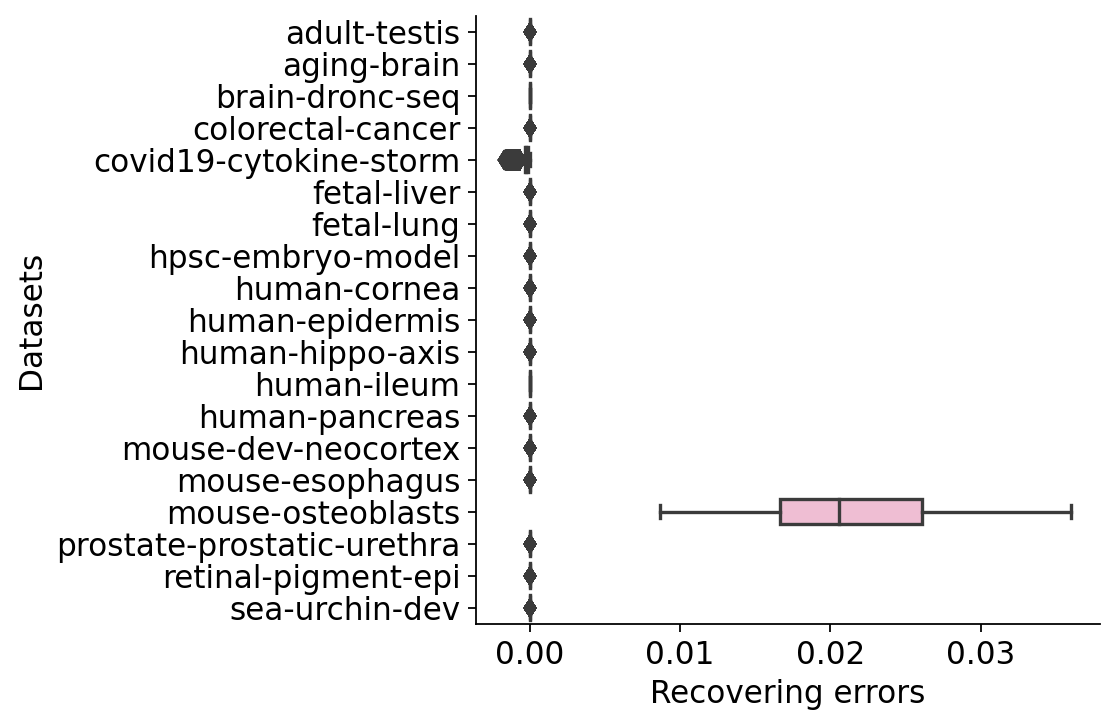

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=recon_ers1[recon_ers1.name!='human-fovea-periphery'],y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Recovering errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/recon_errors2.pdf',dpi=300, bbox_inches='tight',transparent=True)

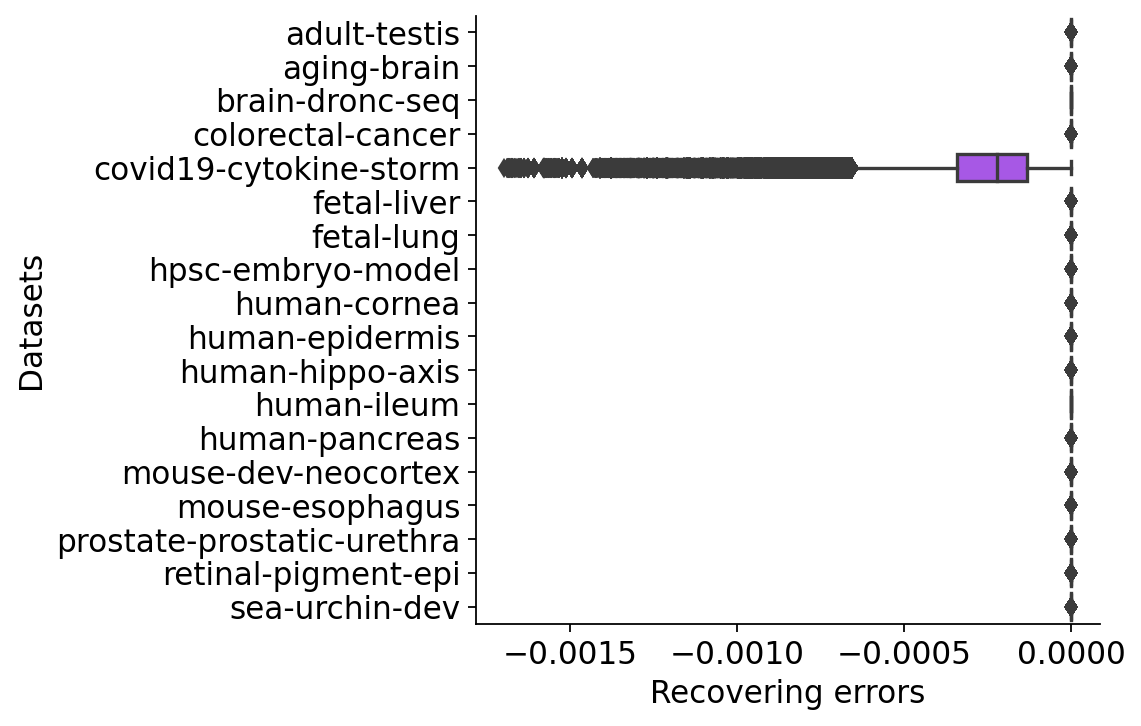

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=recon_ers1[~recon_ers1.name.isin(['human-fovea-periphery','mouse-osteoblasts'])],y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Recovering errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/recon_errors3.pdf',dpi=300, bbox_inches='tight',transparent=True)

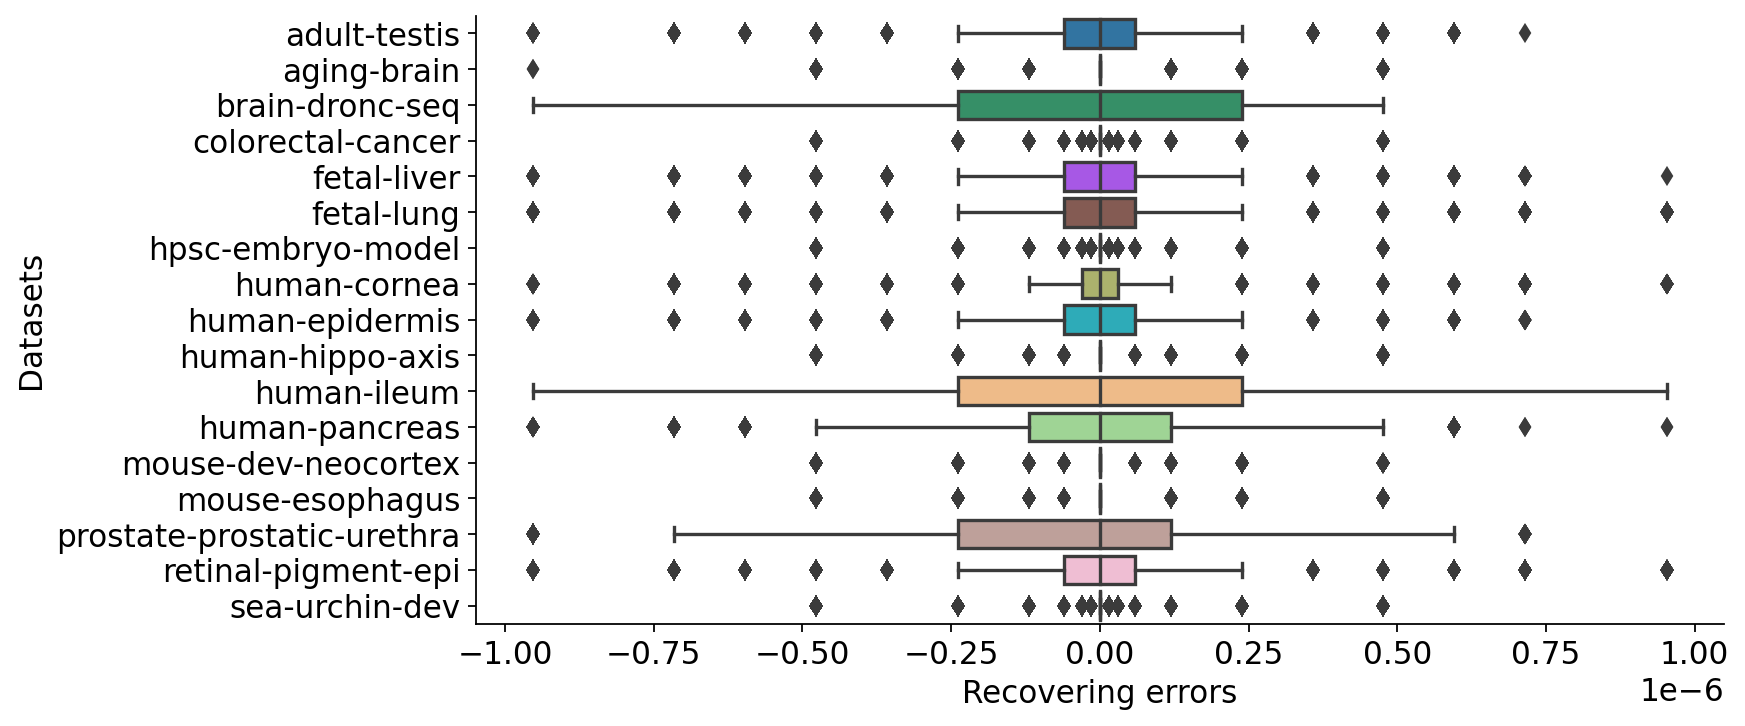

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=recon_ers1[~recon_ers1.name.isin(['covid19-cytokine-storm','human-fovea-periphery','mouse-osteoblasts'])],y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Recovering errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/recon_errors4.pdf',dpi=300, bbox_inches='tight',transparent=True)

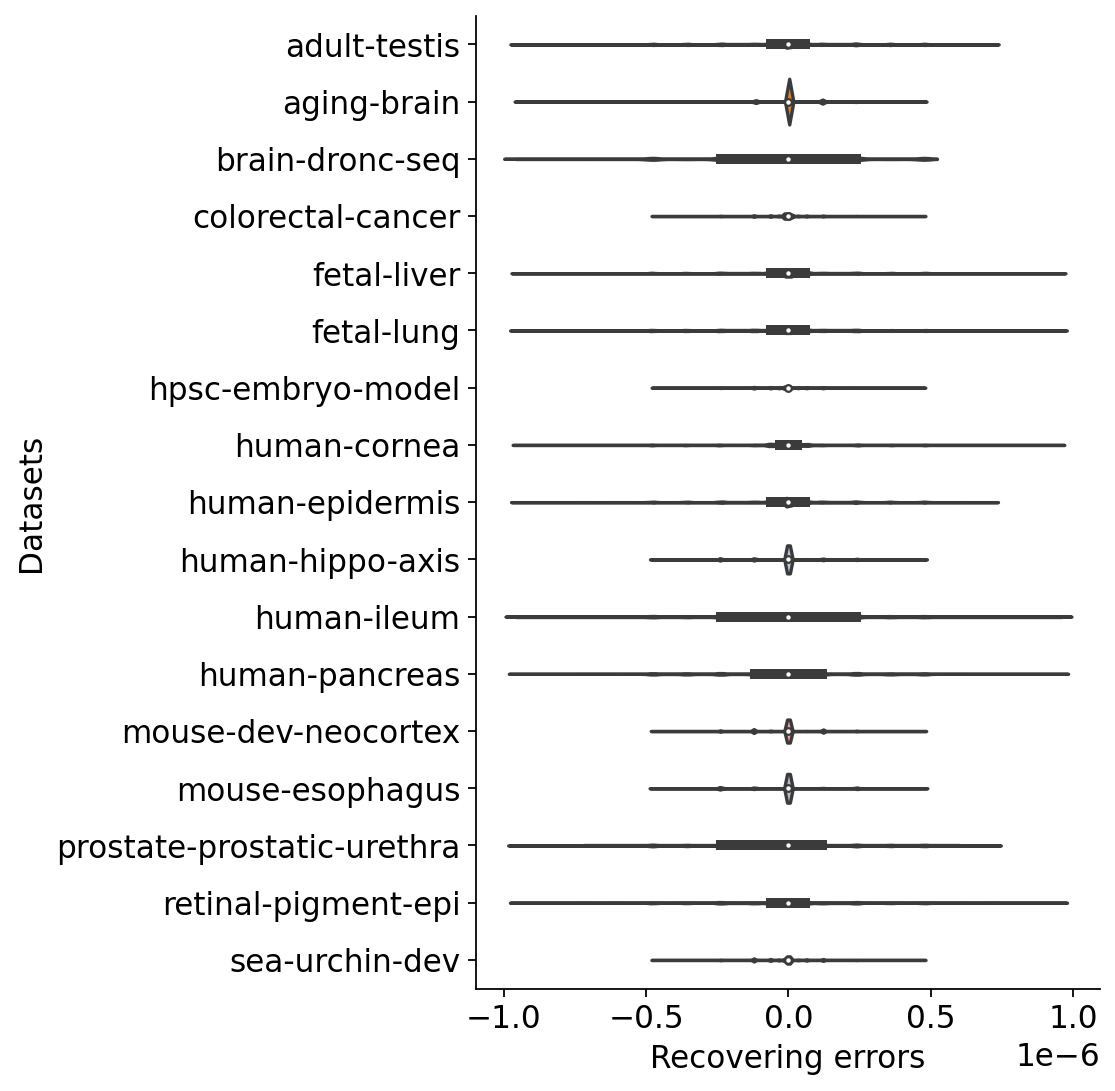

In [ ]:
figsize(5,8)
fig,ax=plt.subplots()
sns.violinplot(data=recon_ers1[~recon_ers1.name.isin(['covid19-cytokine-storm','human-fovea-periphery','mouse-osteoblasts'])],y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Recovering errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/recon_errors4.pdf',dpi=300, bbox_inches='tight',transparent=True)

# plot rounding errors

In [ ]:
len(rounding_ers)

28

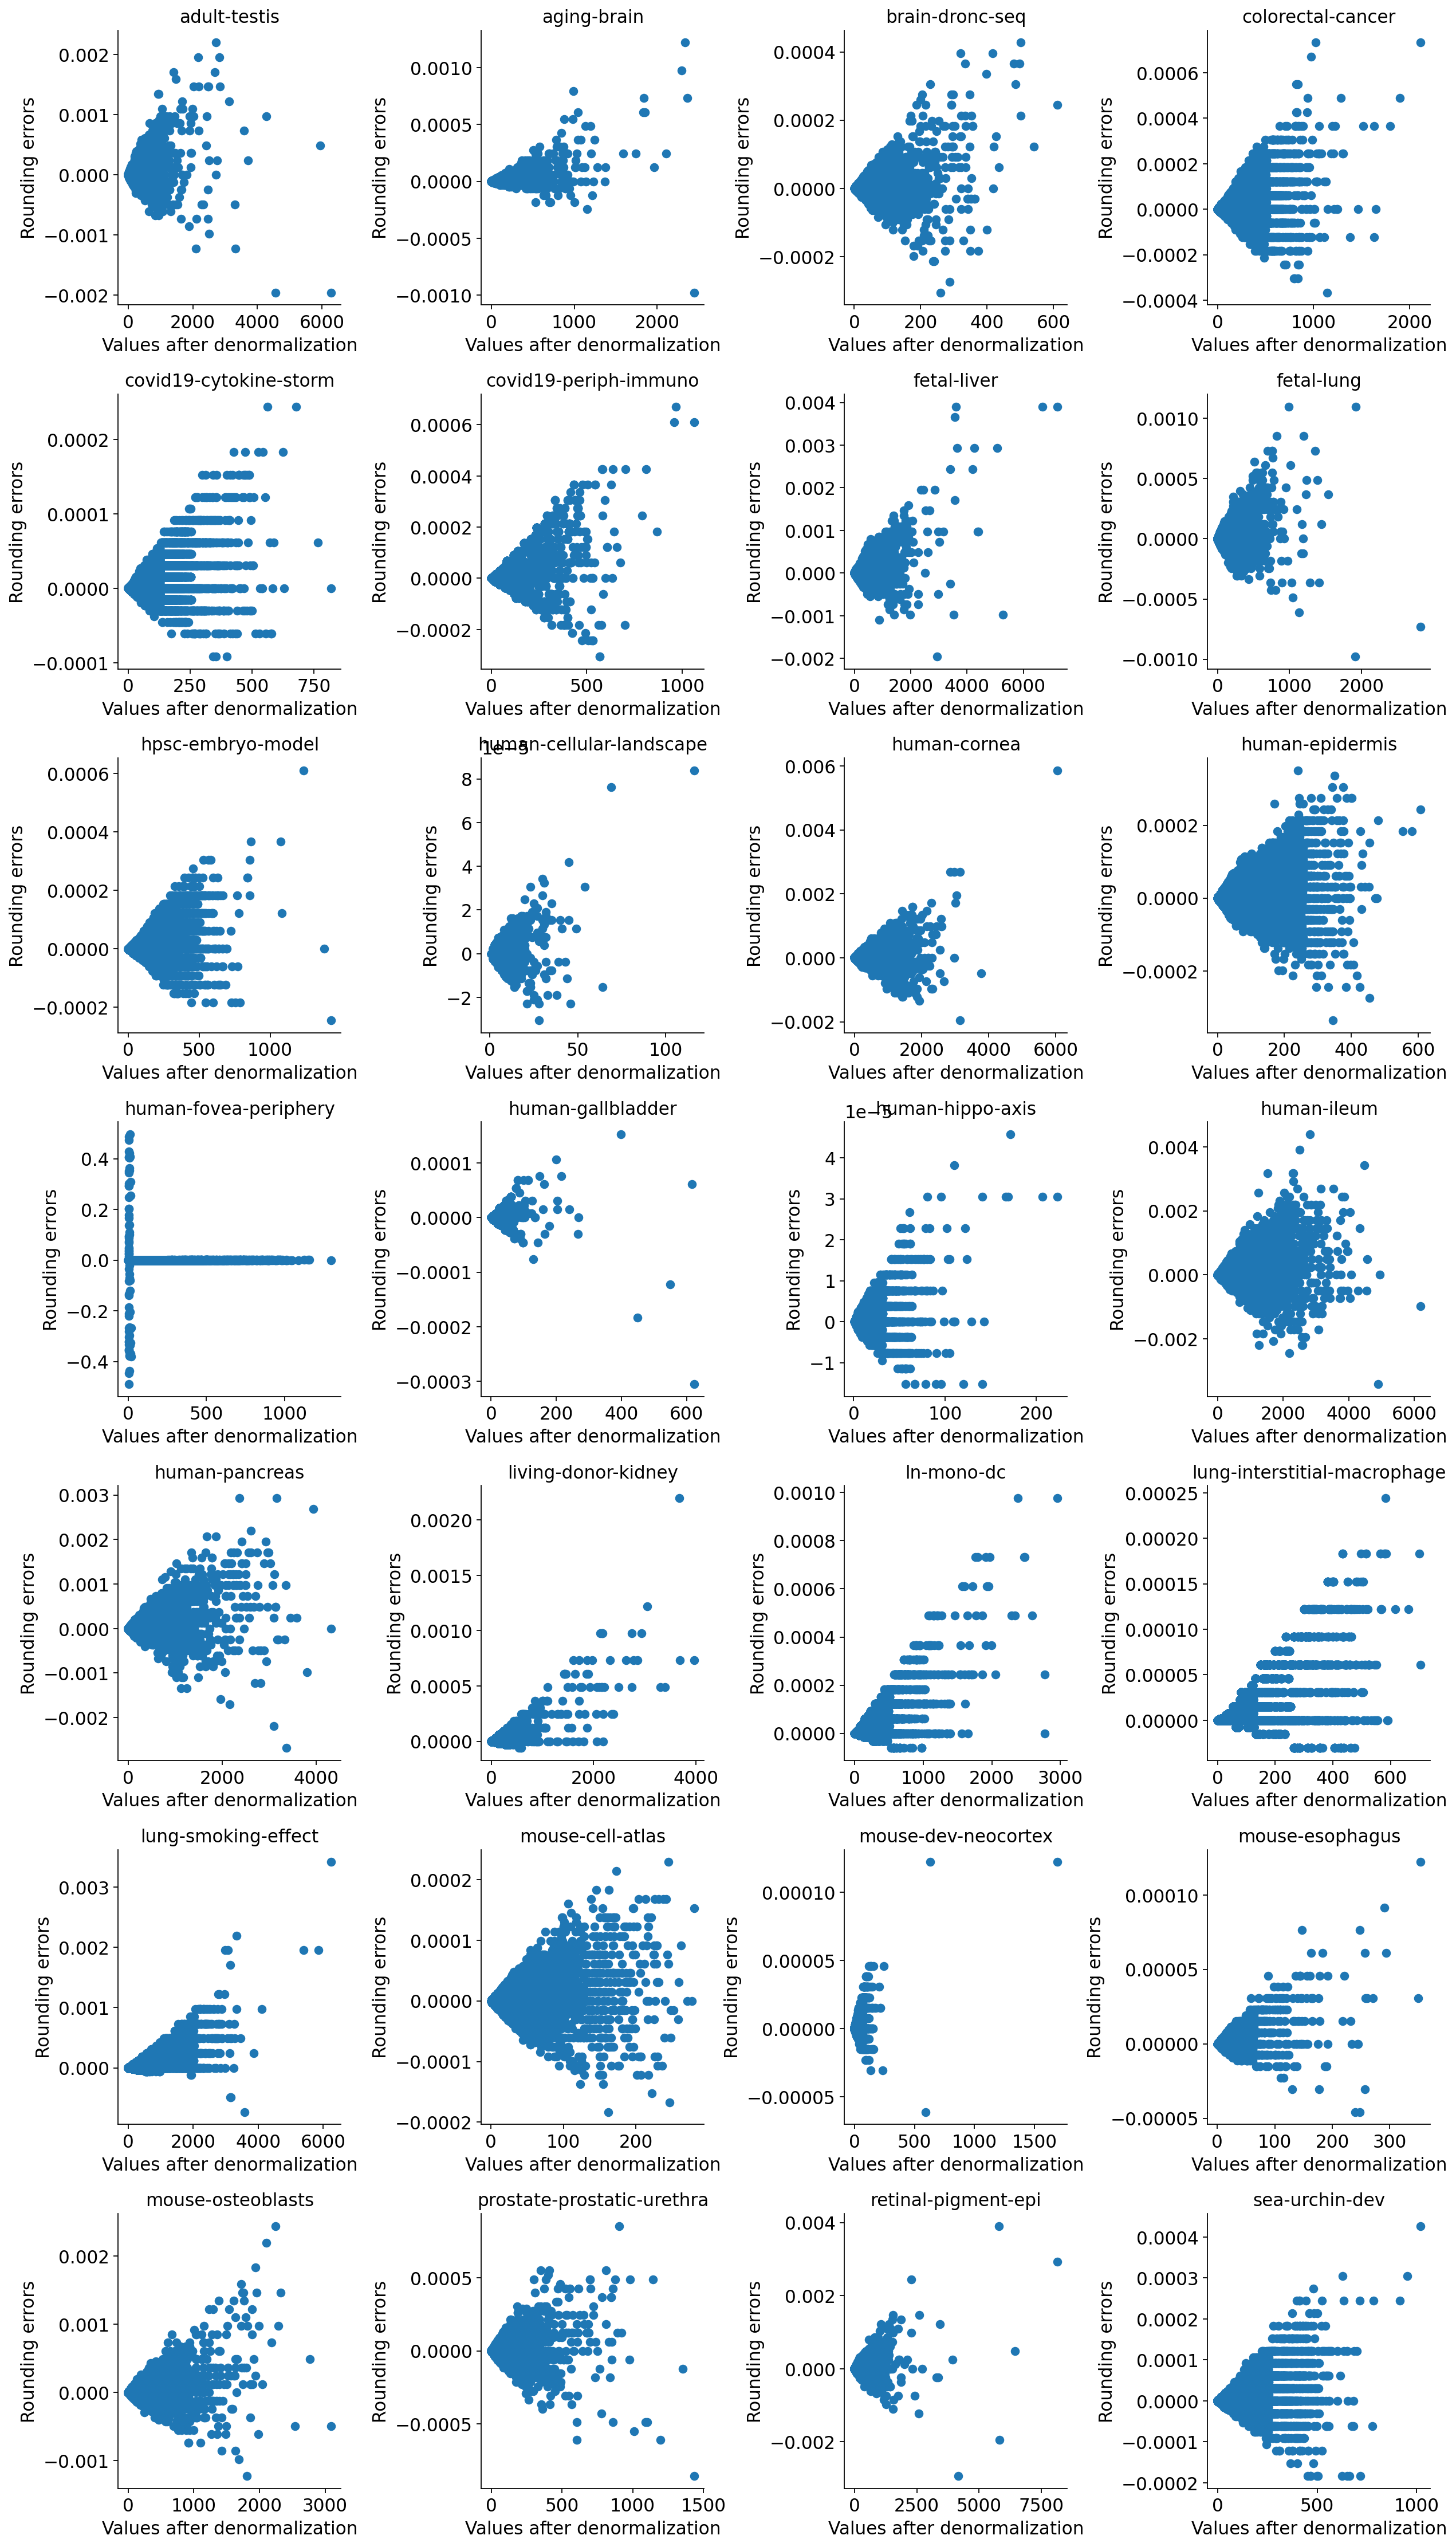

In [ ]:
# Create a 5x4 subplot grid
fig, axs = plt.subplots(7, 4, figsize=(16, 28))

# Loop through each subplot and plot the data
for i in range(7):
    for j in range(4):
        ax = axs[i, j]
        ax.plot(ads_dn[i*4+j].data, rounding_ers[i*4+j].data, 'o')
        ax.grid(visible=False)
        ax.set_xlabel('Values after denormalization')
        ax.set_ylabel('Rounding errors')
        ax.set_title(h5_names[i*4+j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# UCB meta data table

In [ ]:
len(h5_names)

28

In [ ]:
import json
with open("data/dataset.json", "r") as json_file:
    json_data = json.load(json_file)

In [ ]:
x

{'shortLabel': 'Mouse cortex and hippocampus',
 'name': 'zeisel2015',
 'md5': '280b1713b7',
 'hasFiles': ['datasetDesc'],
 'sampleCount': 3005}

In [ ]:
ucb_meta=[]
for x in json_data['datasets']:
    if x['name'] in ads.keys():
        ucb_meta.append([x['name'],x['shortLabel']])

In [ ]:
ucb_meta=pd.DataFrame(ucb_meta,columns=['name','shortLabel'])

In [ ]:
ucb_meta.index=list(ucb_meta.name)
ucb_meta=ucb_meta.sort_index()

In [ ]:
ucb_meta

,name,shortLabel
adult-testis,adult-testis,Adult Testis
aging-brain,aging-brain,Aging Brain
autism,autism,Autism
brain-dronc-seq,brain-dronc-seq,DroNc-seq of Human Brain (Habib et al. 2017.)
cbl-dev,cbl-dev,Human Cerebellar Development
colorectal-cancer,colorectal-cancer,Colorectal Cancer
cortex-dev,cortex-dev,Cortex development
covid19-cytokine-storm,covid19-cytokine-storm,Monocyte-associated Cytokine Storm in Severe C...
covid19-periph-immuno,covid19-periph-immuno,Peripheral Immune in COVID-19 Infection (Wilk ...
fetal-liver,fetal-liver,Fetal Liver and Yolk Sac


In [ ]:
ys

array([array([1.34382105, 1.89721894]),
       array([1.08623397, 1.59456503, 1.92996705]),
       array([1.38233197, 1.94138098]),
       array([0.8160333 , 1.25931895, 1.56538904, 1.79940403, 1.98890901]),
       array([1.06002295, 1.56294799, 1.896016  ]),
       array([1.03445303, 1.531937  , 1.86263704]),
       array([0.89639288, 1.36135995, 1.67751598, 1.91736197]),
       array([1.32425499, 1.87468505]),
       array([0.27169579, 0.48512349, 0.66091502, 0.81037498, 0.94037402,
              1.05540097, 1.15855098, 1.25204897, 1.33754802, 1.416309  ,
              1.48931706, 1.557356  , 1.62105799, 1.68094504, 1.73744702,
              1.79092705, 1.84169102, 1.89000201, 1.93608606, 1.98013997]),
       array([0.52843869, 0.87236547, 1.12779701, 1.33107996, 1.49993801,
              1.64435899, 1.77053106, 1.88255298, 1.98327994])           ,
       array([0.72775853, 1.14450002, 1.43777204, 1.66425502, 1.84879696]),
       array([1.17515302, 1.70060802]),
       array([0.52815

In [ ]:
c.value_counts().sort_index().iloc[:30]

0.693147    3
1.098612    1
1.386294    4
1.609438    1
1.791759    1
2.079442    1
2.197225    1
2.484907    1
2.708050    1
3.713572    1
dtype: int64

In [ ]:
len(ads)

43

In [ ]:
np.random.seed(1)
ress=[]
for i,ad in ads.items():
    print(i)
    smtx2=ad.X.copy()
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            c = c.value_counts().sort_index().head(2)
            if len(c)>1:
                y = np.array(c.index)
                ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    ress.append([i,res.x[0],res.x[1],res.fun])

adult-testis
aging-brain
autism
brain-dronc-seq
cbl-dev
colorectal-cancer
cortex-dev
covid19-cytokine-storm
covid19-periph-immuno
fetal-liver
fetal-lung
gbm
gtex8


/tmp/ipykernel_17721/3415384430.py:2: RuntimeWarning: overflow encountered in power
  return sum((np.power(p[0],y2)-2*np.power(p[0],y1)+p[1])**2)
/tmp/ipykernel_17721/3415384430.py:2: RuntimeWarning: invalid value encountered in subtract
  return sum((np.power(p[0],y2)-2*np.power(p[0],y1)+p[1])**2)
/tmp/ipykernel_17721/3415384430.py:2: RuntimeWarning: overflow encountered in square
  return sum((np.power(p[0],y2)-2*np.power(p[0],y1)+p[1])**2)


h1-esc-diff
head-neck
healthy-bal
hpsc-embryo-model
human-cellular-landscape
human-cornea
human-epidermis
human-fovea-periphery
human-gallbladder
human-hippo-axis
human-ileum
human-liver
human-pancreas
klein-xenopus
living-donor-kidney
ln-mono-dc
lung-interstitial-macrophage
lung-smoking-effect
mouse-cell-atlas
mouse-dev-neocortex
mouse-esophagus
mouse-hypothalamus-dev
mouse-osteoblasts
mouse-skin-stretch
ms
organoidatlas
prostate-prostatic-urethra
retinal-pigment-epi
sea-urchin-dev
zeisel2015


In [ ]:
ress

[['adult-testis',
  2.7182824753672827,
  0.9999999679448754,
  4.3680089102948083e-10],
 ['aging-brain',
  2.7182817865206976,
  0.9999999764632646,
  1.0951312149409683e-10],
 ['autism', 1.999999910792523, 1.0000001413515298, 4.408895002048494e-10],
 ['brain-dronc-seq',
  2.718282664315935,
  0.9999960560969864,
  5.169085839683102e-08],
 ['cbl-dev', 3.9344756307499713, 0.6628491699064414, 0.5026968640796243],
 ['colorectal-cancer',
  2.7182818534677673,
  0.9999999515243102,
  1.0415618454260725e-11],
 ['cortex-dev', 1.9, 0.9672753110373449, 2.5253648981179273],
 ['covid19-cytokine-storm',
  2.718281695324502,
  1.0000000542878855,
  3.883677377891574e-12],
 ['covid19-periph-immuno', 5.526265912738566, 1e-06, 5.582046791344768e-16],
 ['fetal-liver',
  2.7182815619554663,
  1.0000000707566794,
  1.5771852029248406e-10],
 ['fetal-lung', 2.718281596397787, 1.0000002228327631, 4.333537454946307e-10],
 ['gbm', 20.0, 1.0, nan],
 ['gtex8', 1.9, 1.000545198780431, 8.574453523065874e-05],
 [

# human-fovea-periphery

In [ ]:
ads['human-fovea-periphery']

<1000x21599 sparse matrix of type '<class 'numpy.float32'>'
	with 936289 stored elements in Compressed Sparse Row format>

In [ ]:
ad=ads['human-fovea-periphery']
ad1=scdenorm(ad,verbose=1,cutoff=0.5)
ad1.X.sort_indices()

ad2=scdenorm(ad,verbose=1,rint=False,cutoff=0.5)
ad2.X.sort_indices()

tmp2=ad1.X.copy()
tmp2.data=tmp2.data-ad2.X.data

INFO:root:The dimensions of this data are (1000, 21599).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1755.11it/s]
INFO:root:The dimensions of this data are (1000, 21599).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1800.97it/s]


In [ ]:
tmp=ad[((np.abs(tmp2.todense())>0.4).sum(axis=1)>0)]

In [ ]:
total_sum[12][((np.abs(tmp2.todense())>0.1).sum(axis=1)>0)]

,0
13,10007.573242
44,10004.888672
62,10003.188477
85,10004.928711
124,10015.291992
133,10002.219727
148,10012.912109
156,10036.153320
187,10042.358398
196,10007.273438


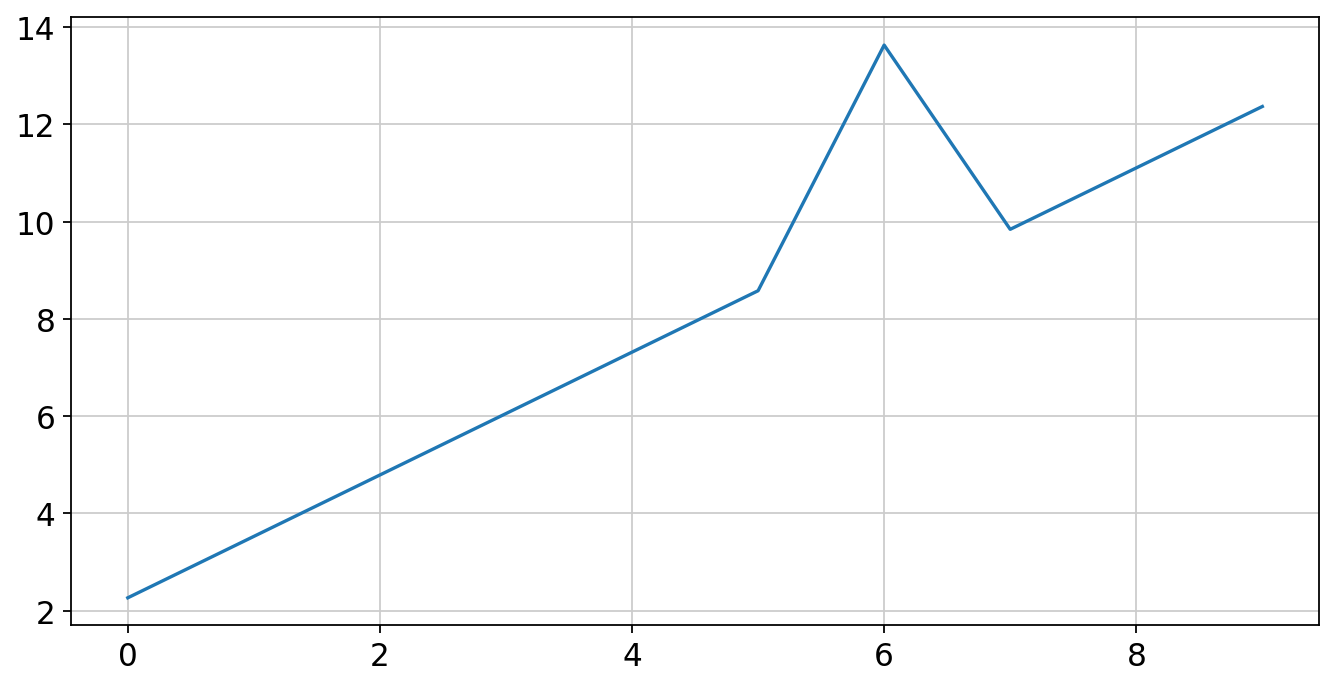

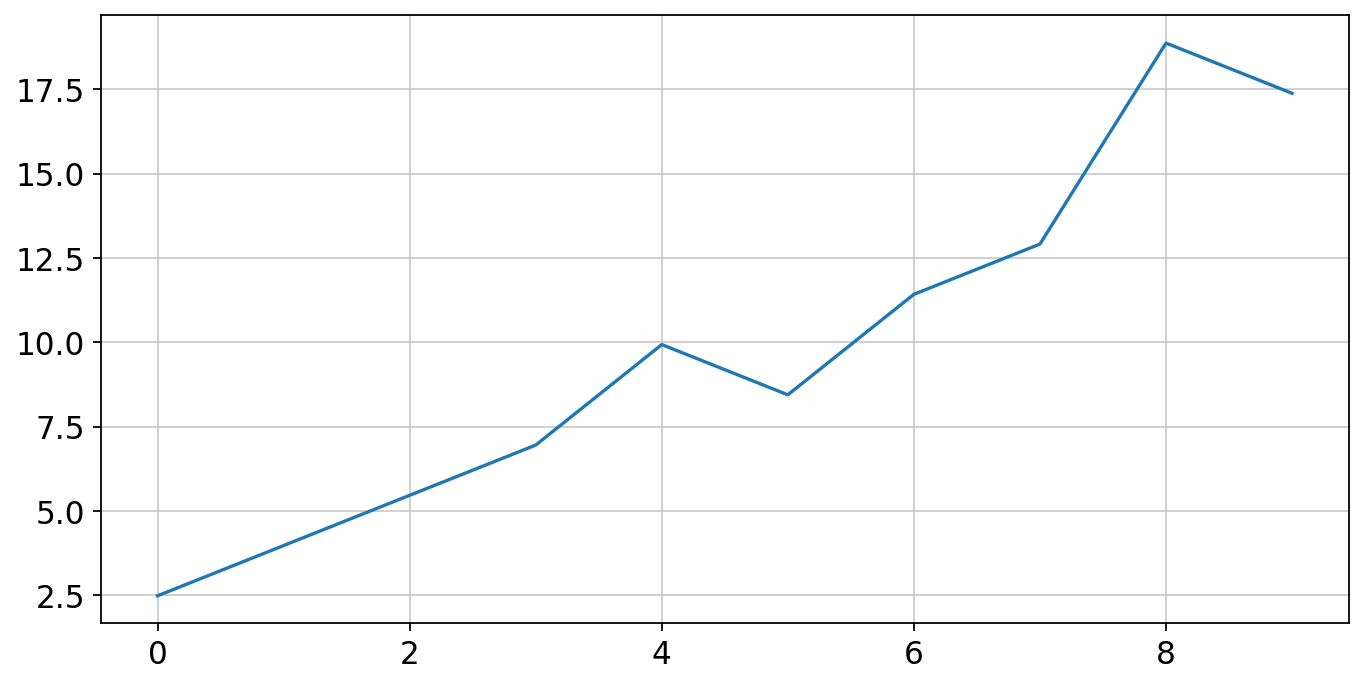

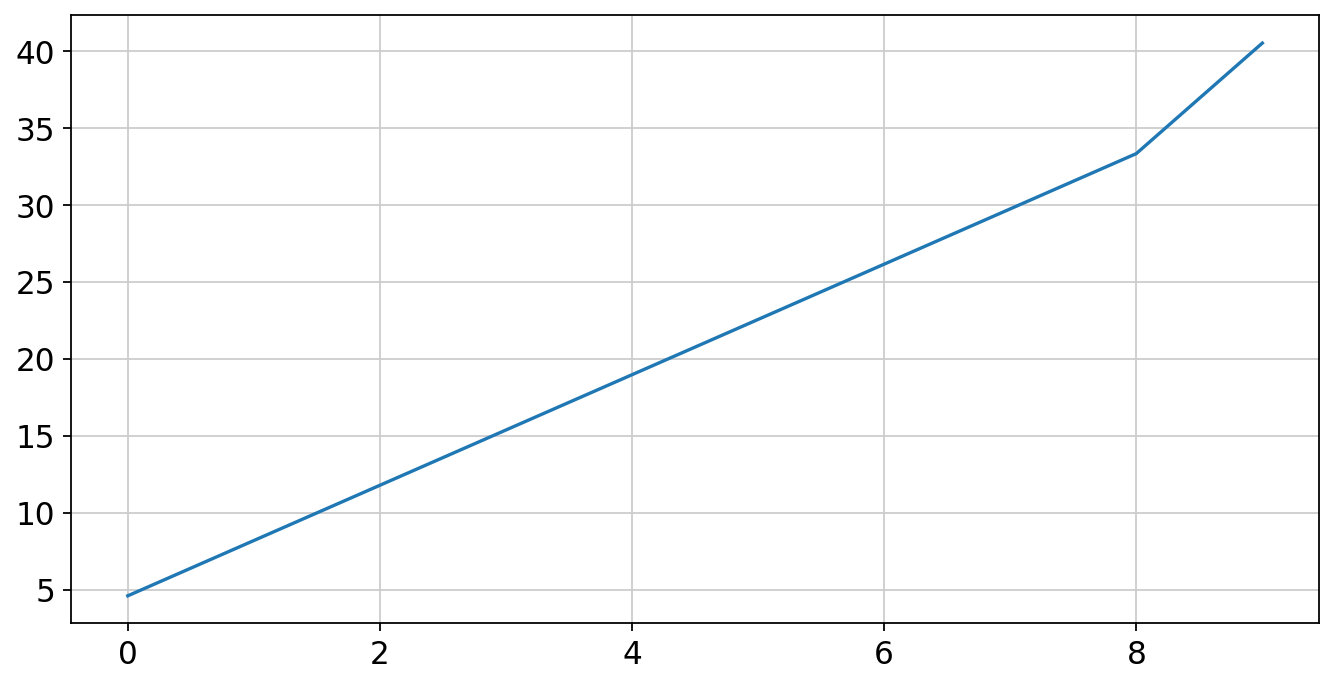

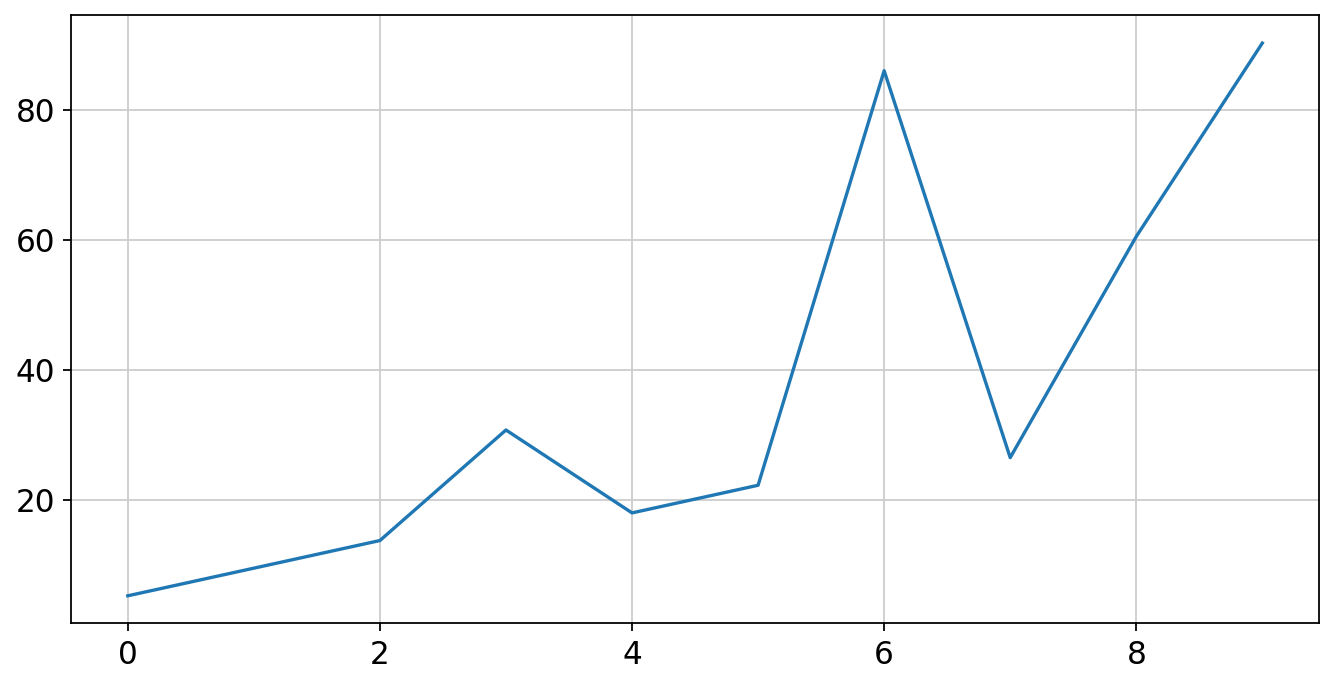

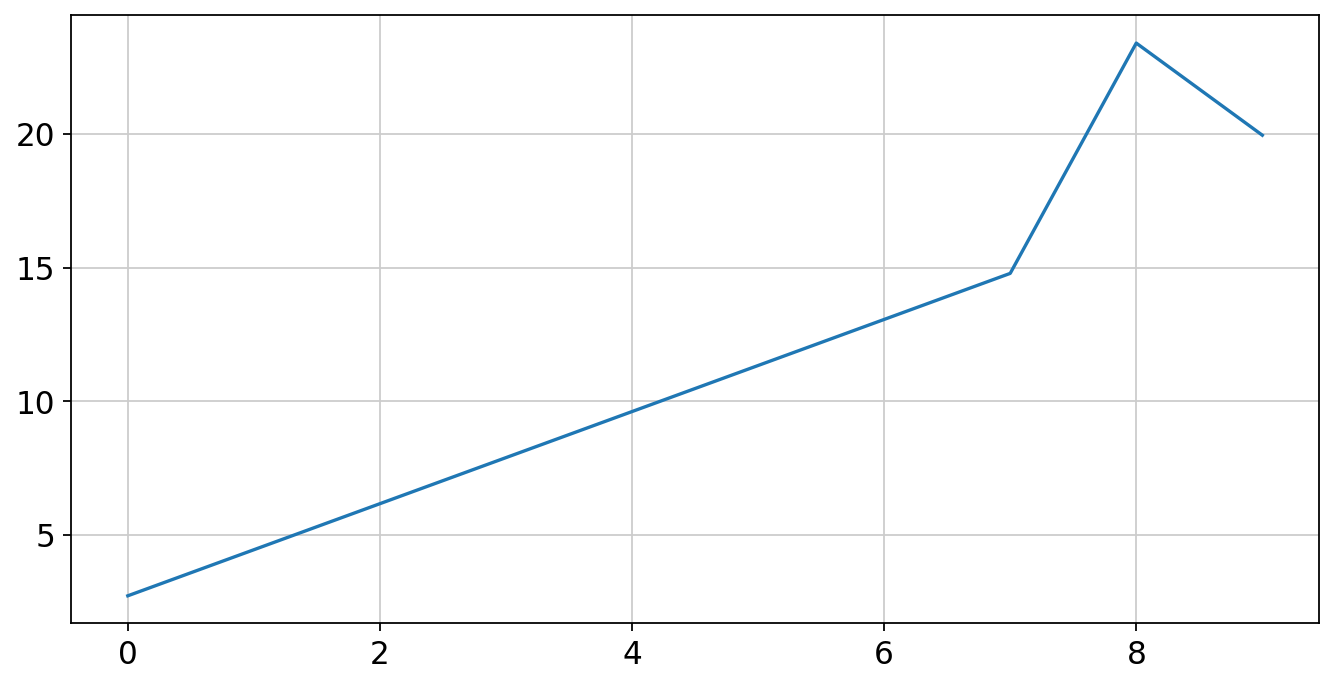

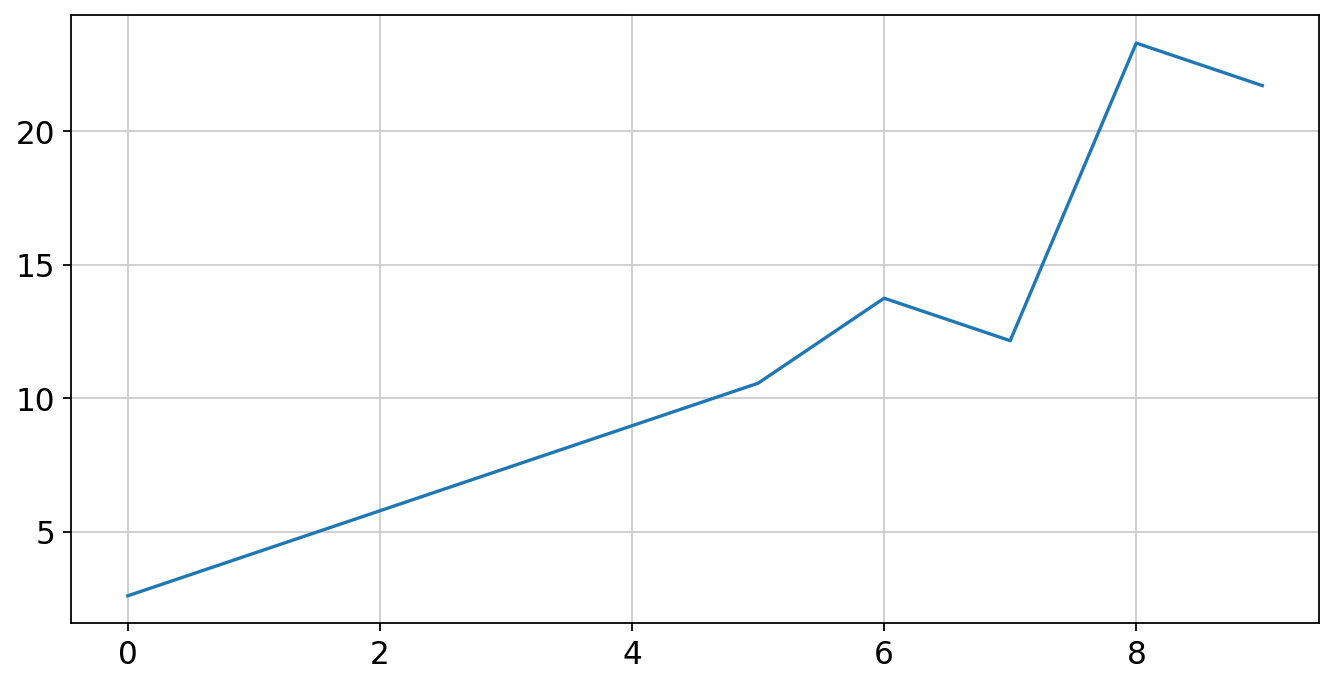

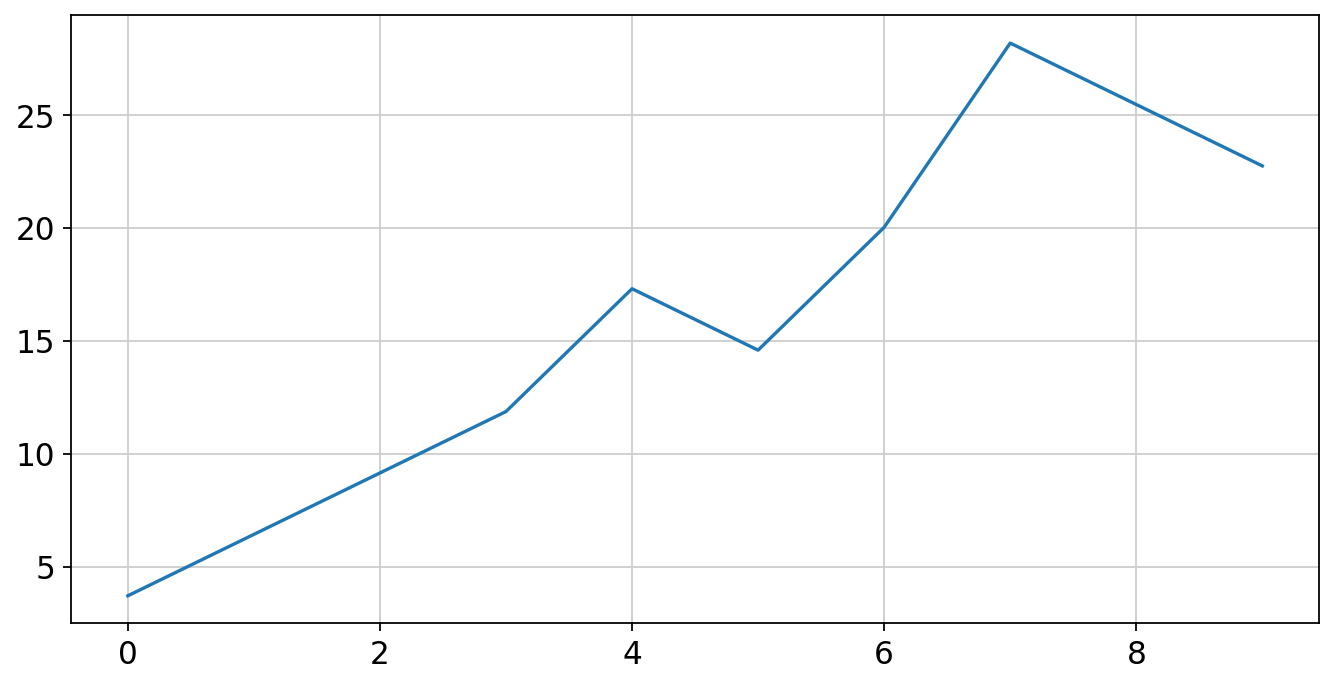

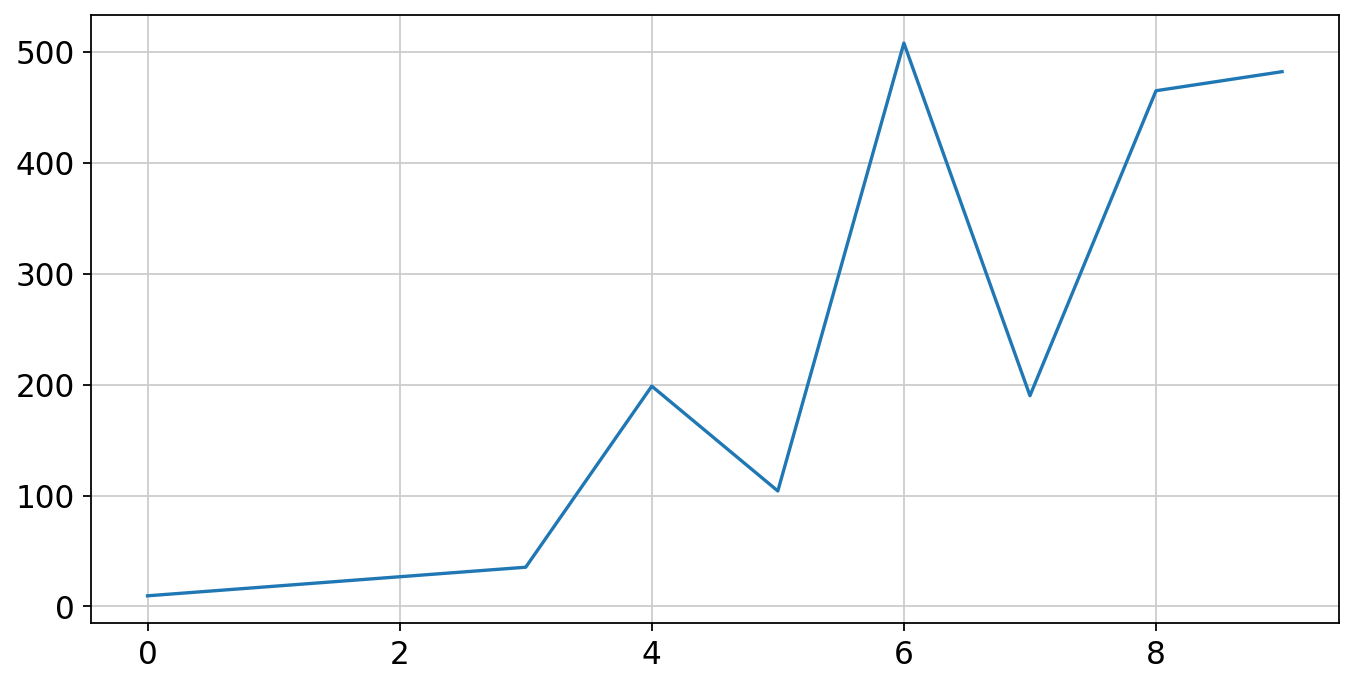

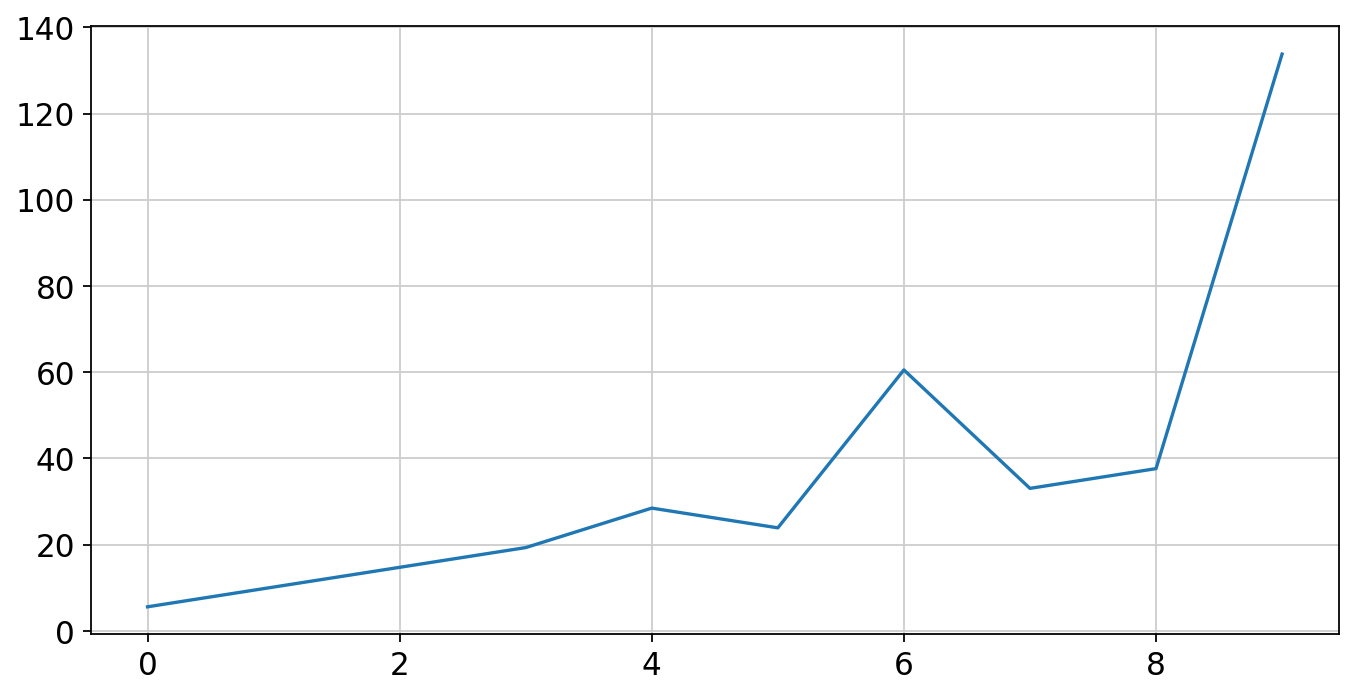

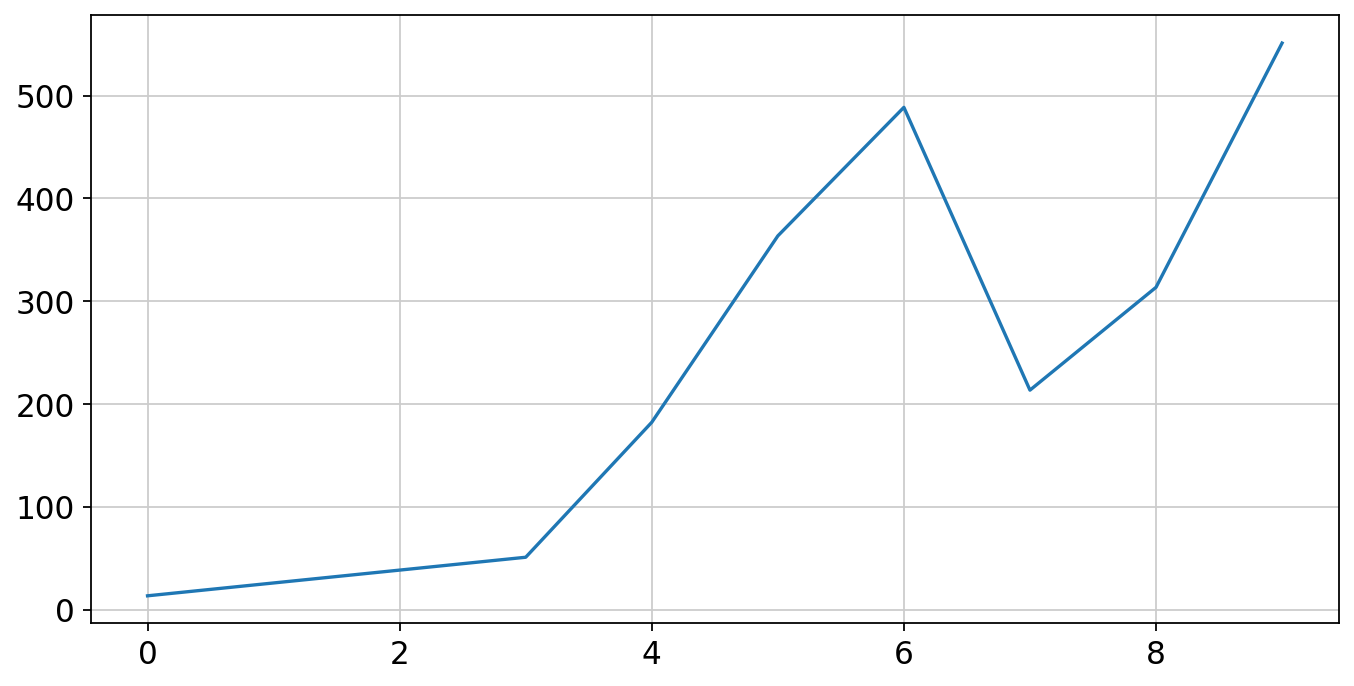

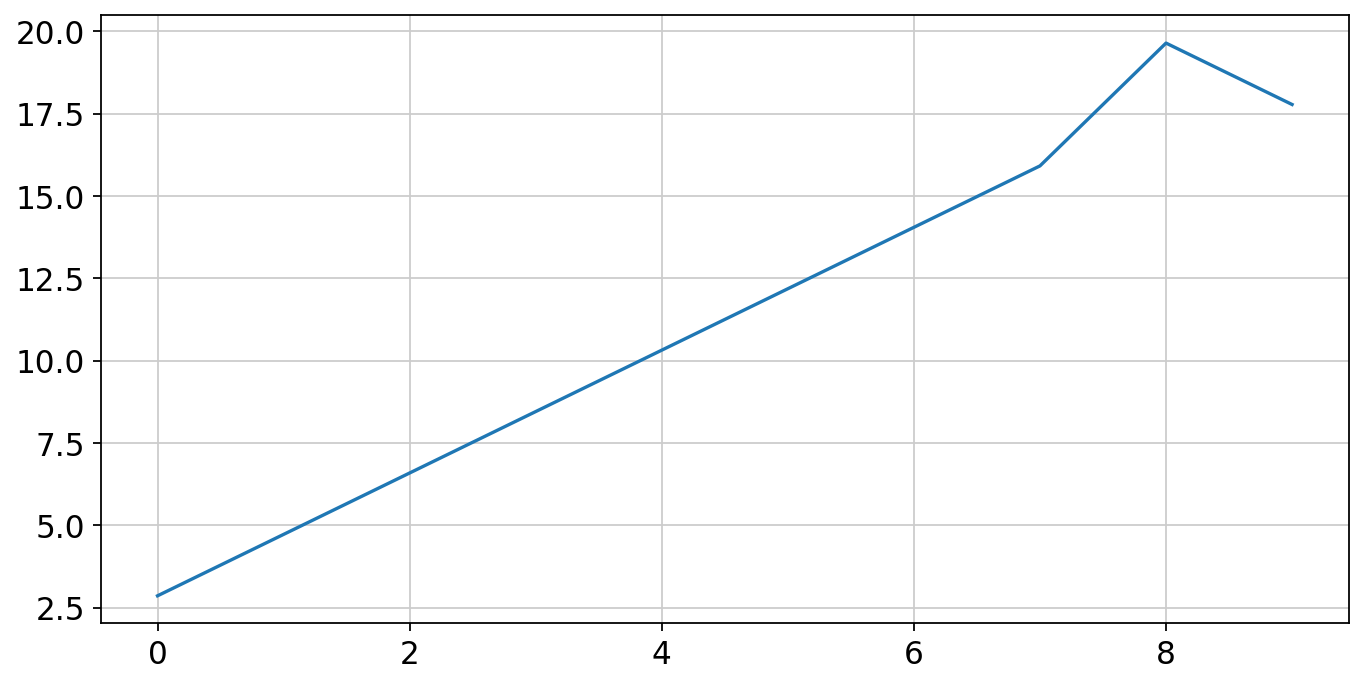

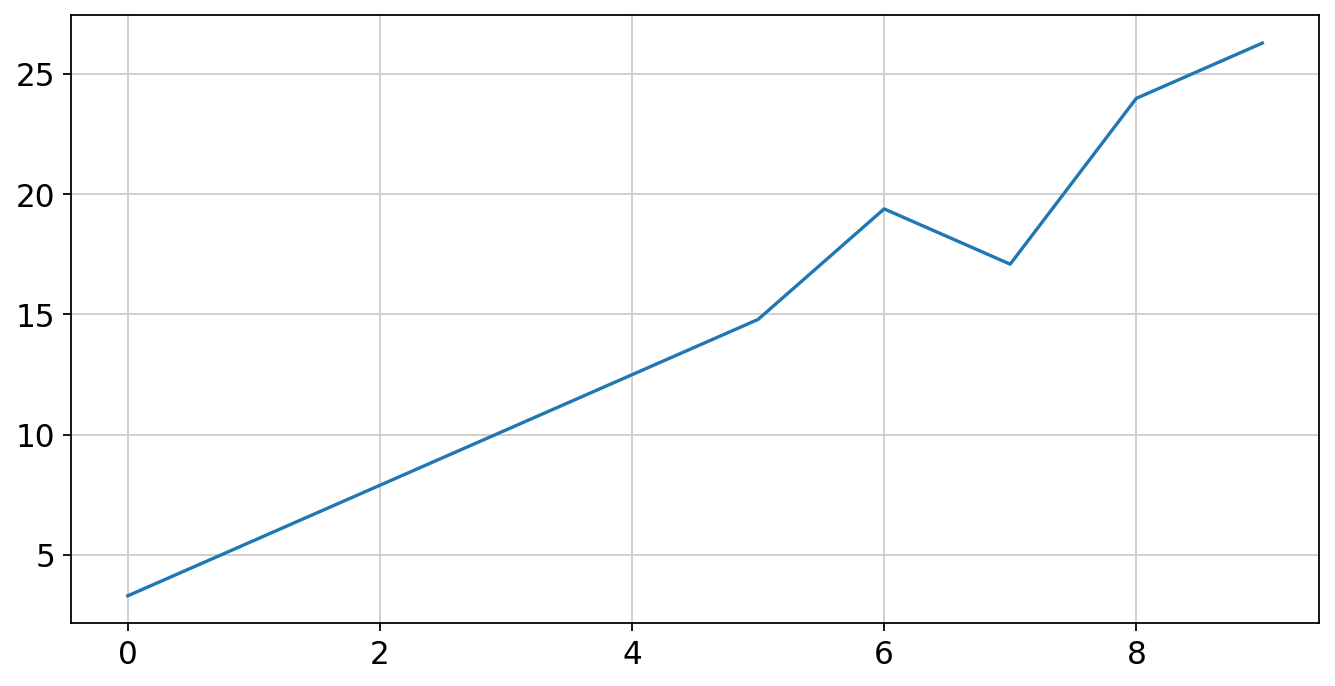

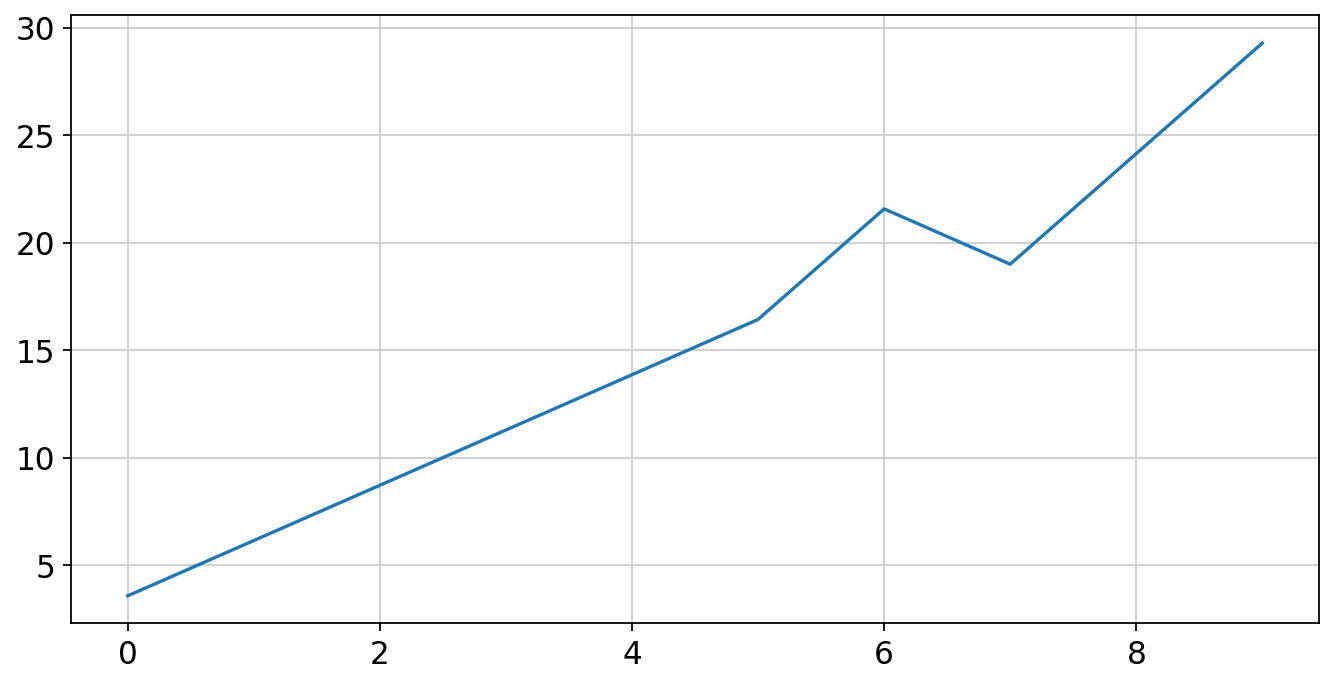

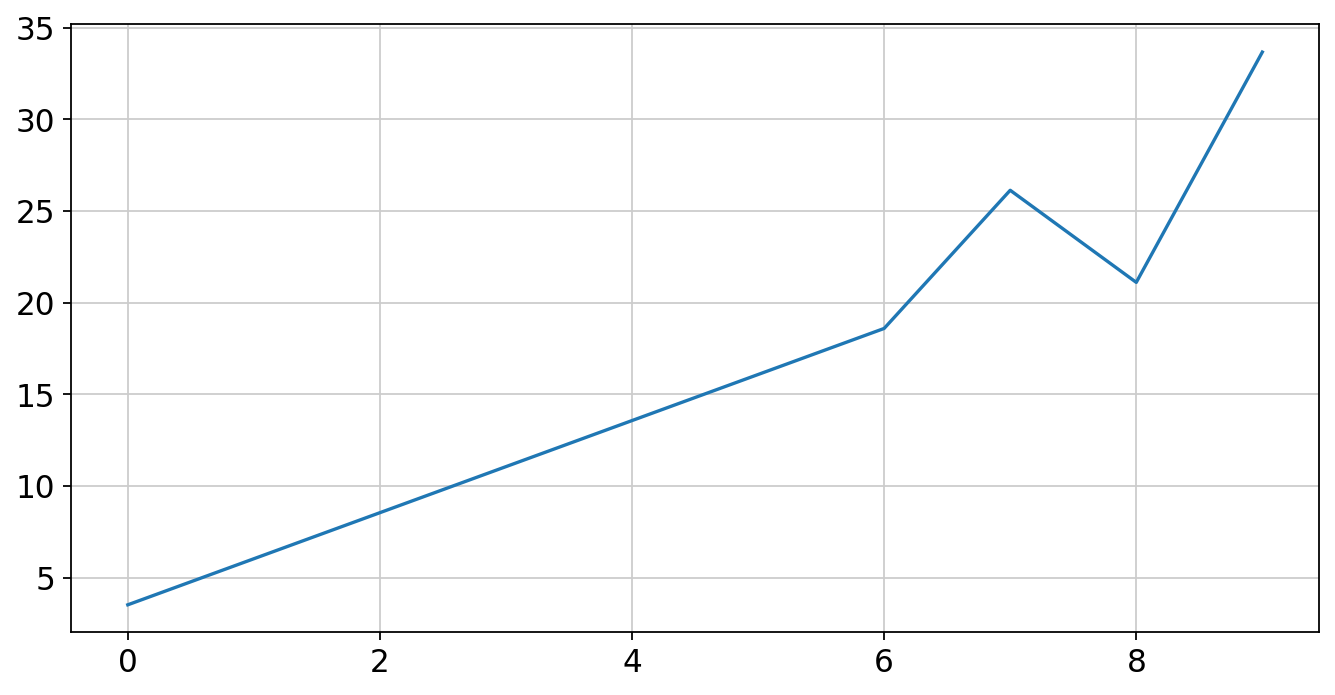

In [ ]:
for i in range(tmp.shape[0]):
    plt.plot(np.exp(pd.Series(tmp[i].X.data).value_counts().index)[:10])
    plt.show()

In [ ]:
def f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    return np.sum((u-y)**2)

def grad_f1(p, x, y):
    u = np.log(p[0]*x+p[2])/np.log(p[1])
    dudx = p[0]/((p[0]*x+p[2])*np.log(p[1]))
    dudp = 1/np.log(p[1])
    grad_u = np.vstack((dudx, np.zeros_like(p[1:]), dudp))
    return 2*np.sum(grad_u*(u-y), axis=1)
bounds = [(1e-6, None), (1.9, None), (1e-6, None)]
#res = minimize(f1, [1, 2.7, 0.1], method='L-BFGS-B', tol=1e-6, bounds=bounds, args=(x, y))

In [ ]:
tmp=[]
for i,ad in ads.items():
    smtx2=ad.X.copy()
    ress=[]
    for N in range(3,16):
        for c_idx in range(10):
            try:
                c = pd.Series(smtx2.getrow(c_idx).data)
                y = np.array(c.value_counts().sort_index().head(N).index)
                x = np.arange(1, N+1)
                res = minimize(f1, [10,20,1], method='L-BFGS-B', tol=1e-10, bounds=bounds, args=(x, y))
                ress.append([res.x[0],res.x[1],res.x[2],res.fun,N,int(res.fun<10**-5)])
            except:
                pass
                #print(c_idx)
    ress=pd.DataFrame(ress,columns=['s','b','c','l','n','p'])
    tmp.append(ress.sort_values('l').head(1))
    print(i,ress.sort_values('l').head(1))

adult-testis            s        b         c             l  n  p
17  2.300456  2.71829  0.999993  9.811340e-15  4  1
aging-brain           s         b         c             l  n  p
0  9.708694  2.718279  1.000012  4.614817e-14  3  1
0
0
2
4
7
0
2
4
7
0
2
4
5
6
7
8
0
2
4
5
6
7
8
0
2
4
5
6
7
8
0
2
4
5
6
7
8
9
0
2
4
5
6
7
8
9
autism             s         b         c             l  n  p
25  12.106569  2.000001  0.999984  1.610004e-13  5  1
1
0
1
4
7
0
1
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
brain-dronc-seq          s         b         c             l  n  p
3  3.85504  2.718279  1.000001  8.904948e-14  3  1
cbl-dev           s          b        c         l  n  p
4  0.040697  23.547017  0.39378  0.000017  3  0
colorectal-cancer           s         b    c             l  n  p
59  0.33205  2.718283  1.0  2.614219e-14  8  1
cortex-dev           s         b         c             l  n  p
4  0.033935  23.99541  0.985892  1.601084e-07  3  1
covid19-cytokine-storm         

In [ ]:
tmp

[           s        b         c             l  n  p
 17  2.300456  2.71829  0.999993  9.811340e-15  4  1,
           s         b         c             l  n  p
 0  9.708694  2.718279  1.000012  4.614817e-14  3  1,
             s         b         c             l  n  p
 25  12.106569  2.000001  0.999984  1.610004e-13  5  1,
          s         b         c             l  n  p
 3  3.85504  2.718279  1.000001  8.904948e-14  3  1,
           s          b        c         l  n  p
 4  0.040697  23.547017  0.39378  0.000017  3  0,
           s         b    c             l  n  p
 59  0.33205  2.718283  1.0  2.614219e-14  8  1,
           s         b         c             l  n  p
 4  0.033935  23.99541  0.985892  1.601084e-07  3  1,
           s         b         c             l  n  p
 12  1.09757  2.718277  1.000001  3.839570e-14  4  1,
            s         b         c             l  n  p
 19  0.999983  2.718261  1.000006  1.426451e-13  4  1,
            s         b         c             l  n 

In [ ]:
[float(x.b) for x in tmp]

[2.718289627799209,
 2.7182785487069885,
 2.000000760481746,
 2.7182793423228655,
 23.54701667121366,
 2.718283295738044,
 23.99540969081976,
 2.718276678201081,
 2.718261456900561,
 2.718275653224485,
 2.7182780411016942,
 25.84236727621895,
 23.596590110720715,
 23.996340549043836,
 23.4104933808176,
 23.372570863803844,
 2.718268932787826,
 2.7182833112583005,
 2.7182327774481942,
 2.718271549259218,
 2.7182709917315324,
 22.741488129761027,
 2.7182818179780206,
 2.7182771857374455,
 2.0000013327972996,
 2.718276735873669,
 23.960157151098144,
 2.7182806809540128,
 2.7182806809540128,
 2.7182806809540128,
 2.7182806809540128,
 2.718256604085138,
 2.7182817538159867,
 2.7182826199762005,
 23.446498077437802,
 2.71826312991601,
 23.51367584456042,
 1.9999851953330219,
 23.53001342694965,
 2.718266543928997,
 2.718276080011955,
 2.7182822574733527,
 2.0006210709189314]

In [ ]:
ucb_meta['base']='NA'

In [ ]:
ucb_meta['base'][[abs(float(x.b)-2)<0.1 for x in tmp]]='2'
ucb_meta['base'][[abs(float(x.b)-2.718)<0.1 for x in tmp]]='e'

/tmp/ipykernel_28146/1661634047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['base'][[abs(float(x.b)-2)<0.1 for x in tmp]]='2'
/tmp/ipykernel_28146/1661634047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['base'][[abs(float(x.b)-2.718)<0.1 for x in tmp]]='e'


In [ ]:
ucb_meta['base']['human-gallbladder']='e'
ucb_meta['base']['klein-xenopus']='1'

/tmp/ipykernel_28146/618824187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['base']['human-gallbladder']='e'
/tmp/ipykernel_28146/618824187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['base']['klein-xenopus']='1'


In [ ]:
ucb_meta['genes']=[ad.shape[1] for ad in ads.values()]

In [ ]:
ucb_meta['method']='logNorm'
ucb_meta['method']['cbl-dev']='log2(RPKM)'
ucb_meta['method']['cortex-dev']='TPM'
ucb_meta['method']['gbm']='(CPM)/100+1'
ucb_meta['method']['gtex8']='TPM'
ucb_meta['method']['h1-esc-diff']='log2(FPKM+1)'
ucb_meta['method']['head-neck']='log2(TPM/10+1)'
ucb_meta['method']['healthy-bal']='SCTransform'
ucb_meta['method']['mouse-hypothalamus-dev']='SCTransform'
ucb_meta['method']['mouse-skin-stretch']='scran'
ucb_meta['method']['organoidatlas']='scaled logNorm'
ucb_meta['method']['klein-xenopus']='Norm'

/tmp/ipykernel_28146/10773711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['method']['cbl-dev']='log2(RPKM)'
/tmp/ipykernel_28146/10773711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['method']['cortex-dev']='TPM'
/tmp/ipykernel_28146/10773711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['method']['gbm']='(CPM)/100+1'
/tmp/ipykernel_28146/10773711.py:5: SettingWithCopyWarning: 
A value is

In [ ]:
ucb_meta

,name,shortLabel,base,genes,method
adult-testis,adult-testis,Adult Testis,e,27826,logNorm
aging-brain,aging-brain,Aging Brain,e,19746,logNorm
autism,autism,Autism,2,36501,logNorm
brain-dronc-seq,brain-dronc-seq,DroNc-seq of Human Brain (Habib et al. 2017.),e,25587,logNorm
cbl-dev,cbl-dev,Human Cerebellar Development,NA,2000,log2(RPKM)
colorectal-cancer,colorectal-cancer,Colorectal Cancer,e,33694,logNorm
cortex-dev,cortex-dev,Cortex development,NA,56865,TPM
covid19-cytokine-storm,covid19-cytokine-storm,Monocyte-associated Cytokine Storm in Severe C...,e,18670,logNorm
covid19-periph-immuno,covid19-periph-immuno,Peripheral Immune in COVID-19 Infection (Wilk ...,e,26361,logNorm
fetal-liver,fetal-liver,Fetal Liver and Yolk Sac,e,26349,logNorm


In [ ]:
ucb_meta['base']=ucb_meta['base'].astype('category').cat.reorder_categories(['1','2','e','NA'])

In [ ]:
ucb_meta['method']=ucb_meta['method'].astype('category').cat.reorder_categories(['logNorm','Norm', 'log2(RPKM)', 
       'log2(FPKM+1)', 'log2(TPM/10+1)', 'TPM', 'SCTransform','(CPM)/100+1', 'scran', 'scaled logNorm'])

In [ ]:
ucb_meta['method1']=list(ucb_meta['method'])
ucb_meta['method1'][~ucb_meta['method1'].isin(['logNorm','Norm'])]='Other'
ucb_meta['method1'][ucb_meta['method1'].isin(['logNorm'])]='LogNorm'

/tmp/ipykernel_28146/634543920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['method1'][~ucb_meta['method1'].isin(['logNorm','Norm'])]='Other'
/tmp/ipykernel_28146/634543920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['method1'][ucb_meta['method1'].isin(['logNorm'])]='LogNorm'


In [ ]:
ucb_meta=ucb_meta.sort_values('base')

In [ ]:
ucb_meta

,name,shortLabel,base,genes,method
klein-xenopus,klein-xenopus,Klein-lab Xenopus,1,26550,Norm
zeisel2015,zeisel2015,Mouse cortex and hippocampus,2,19972,logNorm
autism,autism,Autism,2,36501,logNorm
ms,ms,Multiple Sclerosis,2,33741,logNorm
human-liver,human-liver,Human Liver,2,20007,logNorm
human-hippo-axis,human-hippo-axis,Human Hippocampal Axis,e,17180,logNorm
human-ileum,human-ileum,Human Ileum,e,22340,logNorm
human-pancreas,human-pancreas,Human Pancreas,e,16077,logNorm
living-donor-kidney,living-donor-kidney,Living Donor Kidney,e,22484,logNorm
ln-mono-dc,ln-mono-dc,Migratory Dendritic Cells Direct Monocytes int...,e,17863,logNorm


In [ ]:
ucb_meta.to_csv('data/ucb_meta.csv')

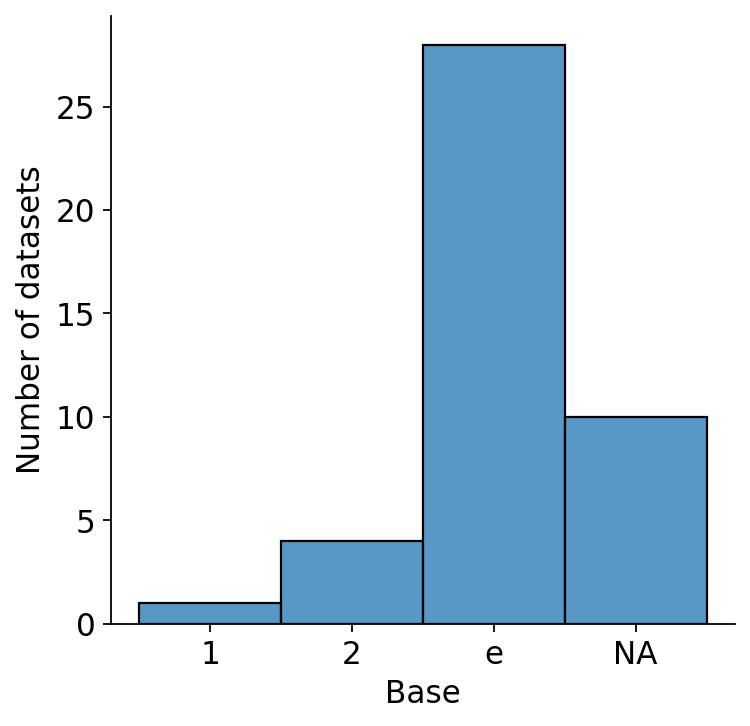

In [ ]:
figsize(5,5)
sns.histplot(x='base',data=ucb_meta)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Base')
plt.ylabel('Number of datasets')
plt.savefig('figures/UCB/ucb_meta0.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
ucb_meta=pd.read_csv('data/ucb_meta.csv',index_col=0)

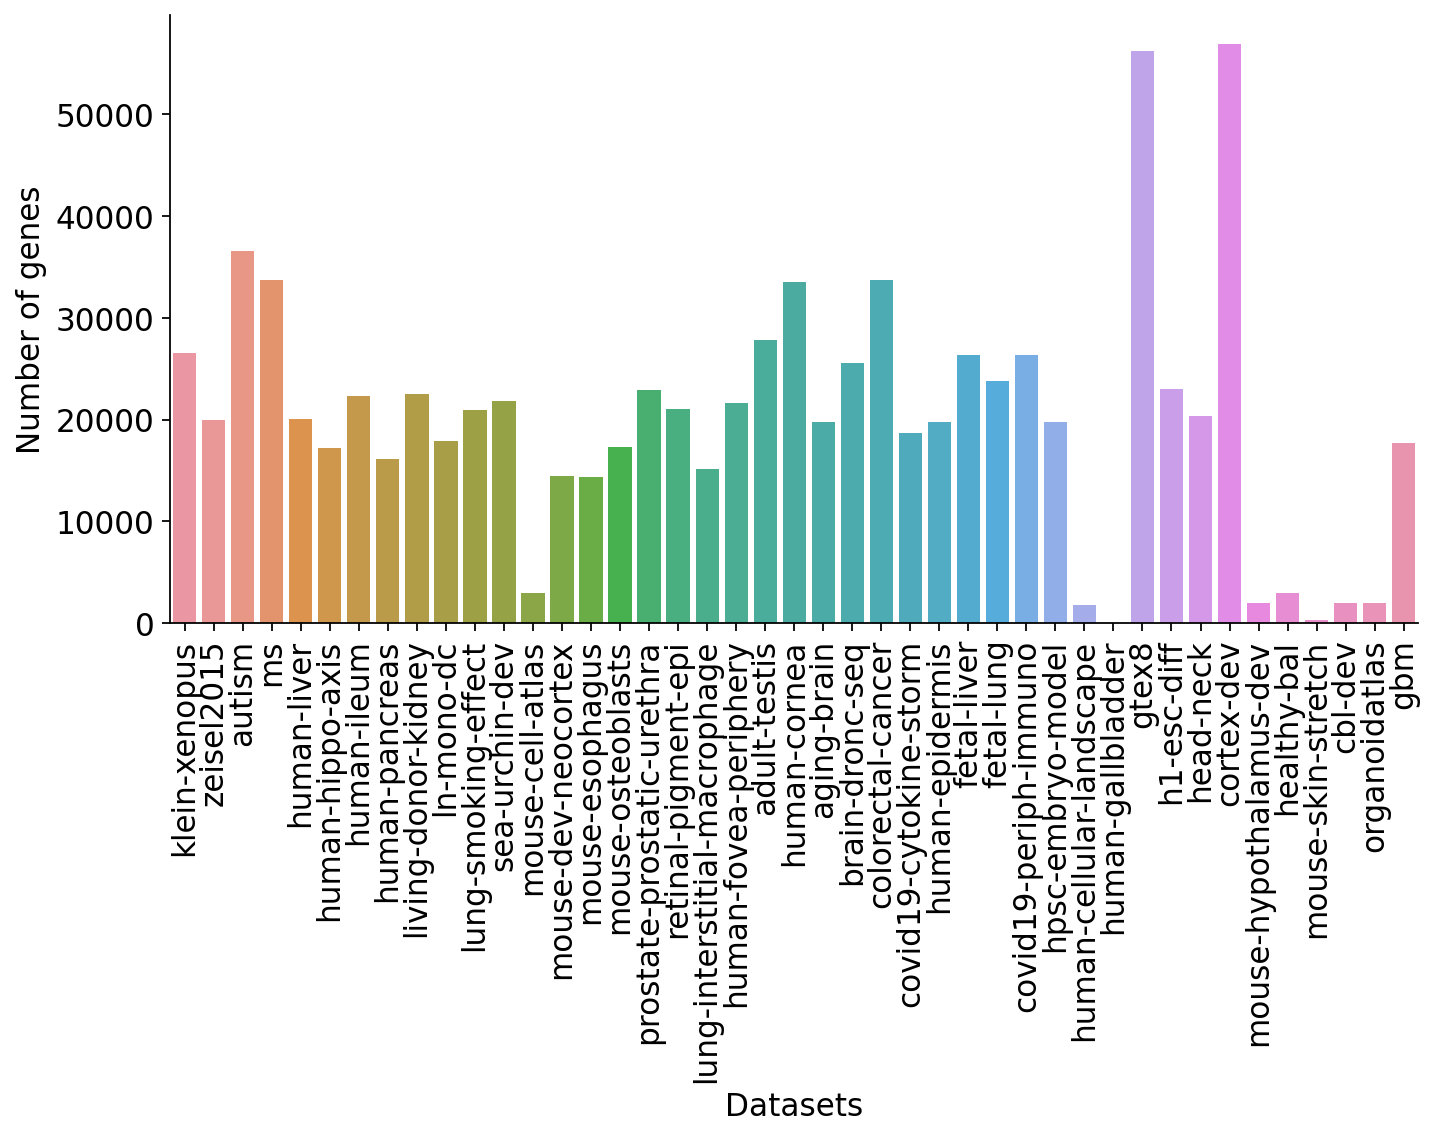

In [ ]:
figsize(10,5)
sns.barplot(x='name',y='genes',data=ucb_meta)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Datasets')
plt.ylabel('Number of genes')
plt.xticks(rotation=90)
plt.savefig('figures/UCB/ucb_meta1.pdf',dpi=300, bbox_inches='tight',transparent=True)

([<matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>],
 [Text(0.8899186877588753, 0.6465637858537406, 'TPM'),
  Text(-0.3399187231970732, 1.046162158377023, 'SCTransform'),
  Text(-1.0461621822461362, 0.3399186497354952, 'log2(FPKM+1)'),
  Text(-1.0461621504206509, -0.33991874768426583, 'log2(TPM/10+1)'),
  Text(-0.6465637233635886, -0.8899187331606258, 'scran'),
  Text(7.724207457870327e-08, -1.0999999999999974, 'log2(RPKM)'),
  Text(0.6465638483438898, -0.88991864235712, 'scaled logNorm'),
  Text(1.0461621981588753, -0.33991860076110864, '(CPM)/100+1')])

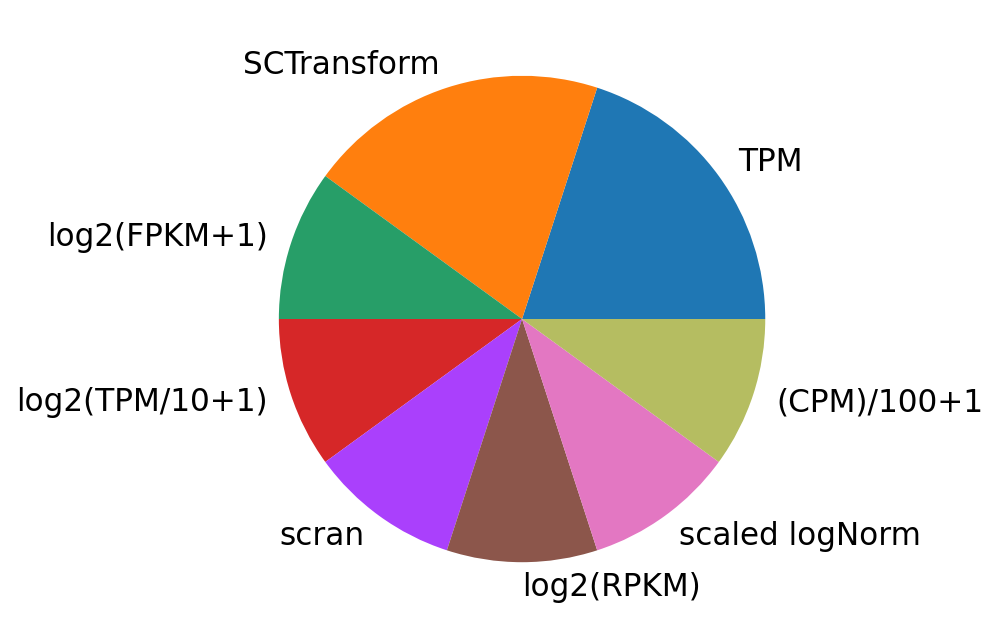

In [ ]:
values = ucb_meta['method'][ucb_meta['base'].isna()].value_counts()
plt.pie(values, labels=values.index)

<AxesSubplot:xlabel='method', ylabel='Count'>

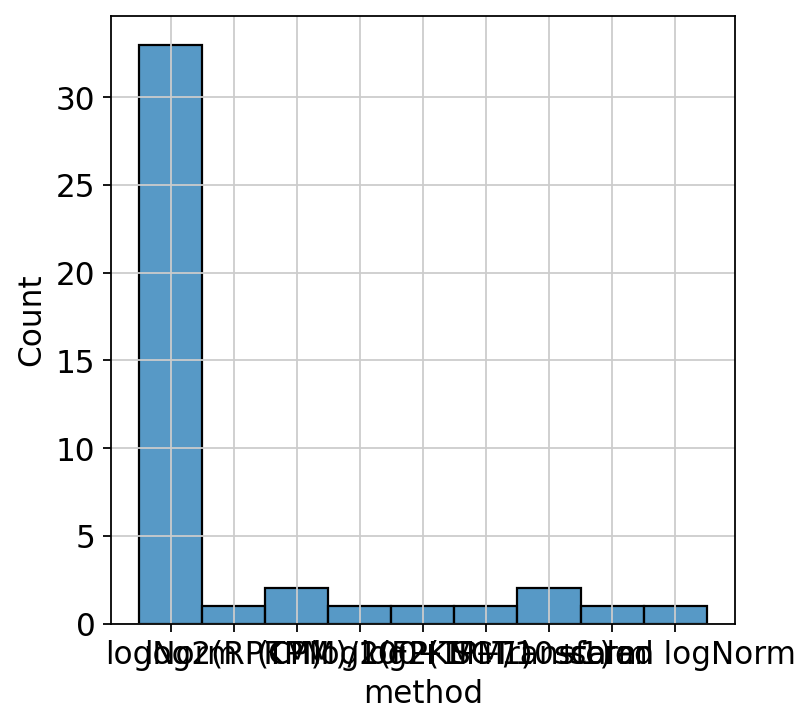

In [ ]:
sns.histplot(x='method',data=ucb_meta)

In [ ]:
ress.sort_values('l').head(1)

,s,b,c,l,n,p
0,1.000932,2.000621,0.999689,5.695002e-13,3,1


In [ ]:
ress

,s,b,c,l,n,p


# plot MV before and after scDenorm

# plot Cells

In [ ]:
def solve_bc(p,y1,y2):
    return sum((np.power(p[0],y2)-2*np.power(p[0],y1)+p[1])**2)

In [ ]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [ ]:
def auto_detect_error(ad,base,pseudo,total,num=10,seed=0):
    np.random.seed(seed)
    #normalization
    ad=ad.copy()
    sc.pp.normalize_total(ad, target_sum=total)
    smtx2=ad.X
    smtx2.data=np.log(smtx2.data+pseudo)/np.log(base)
    print(smtx2.data)
    #minimize
    ress=[]
    for _ in range(num):
        ys=[]
        for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
            try:
                c = pd.Series(smtx2.getrow(c_idx).data)
                y = np.array(c.value_counts().sort_index().head(2).index)
                ys.append(y)
            except:
                print(c_idx)
        ys=np.array(ys)
        y1=ys[:,0]
        y2=ys[:,1]
        res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
        ress.append([res.x[0],res.x[1],res.fun])
    return pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
smtx2=ad.X.copy()

##### auto 1

In [ ]:
np.random.seed(0)
num=100
ress=[]
for _ in range(num):
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    ress.append([res.x[0],res.x[1],res.fun])

In [ ]:
ress=pd.DataFrame(ress,columns=['base','pseudo','loss'])

In [ ]:
ress

,base,pseudo,loss
0,2.718282,1.0,5.750709e-10
1,2.718283,1.0,3.684890e-10
2,2.718281,1.0,4.137832e-10
3,2.718283,1.0,2.799222e-10
4,2.718282,1.0,3.852907e-10
...,...,...,...
95,2.718283,1.0,3.243977e-10
96,2.718282,1.0,4.506178e-10
97,2.718283,1.0,3.535000e-10
98,2.718282,1.0,6.388147e-10


In [ ]:
ress.base.mean()

2.718282409851444

# EOF